<a href="https://colab.research.google.com/github/jeguienta/ProjetNLP_ENSAE/blob/master/Projet_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identifying political affiliation from Parliamentary Speeches**
## **NLP PROJECT**
### Janine Eguienta & Sarah Oulkadi




In this work, we are focusing on a document-level classification task. We want to see whether it is possible to predict the political affiliation of a speaker given his speech. 

We have at our disposal speeches of MPs in the Canadian Parliament, available online at the following address : http://lipad.ca/data/.

**Each speech is a sequence of words of varying length and the political affiliation of the speaker must be classified.**

In order to do this, we implement and compare two sequence labelling models : bi-LSTM and HAN, which are both commonly used for document-level classification purposes.




*Outline of the notebook*
1.   Data collection
2.   Data description
3.   Baseline models
4.   Sequence models


## **Preliminaries**


**WARNING: if the following chunk outputs a warning, please change the execution type of your environment to GPU.**

In [0]:
import torch 
import warnings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available() == False:
  warnings.warn("CUDA not activated, please activate CUDA")

**Herebelow is the list of the packages we use to carry out our analysis.**


In [2]:
# Basic packages
import pandas as pd
import numpy as np
import random


# General packages 
from google.colab import drive 
import os
import glob
import time

# Statistical packages
import statsmodels as sm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier


# Plot packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


# NLP packages
import re
import nltk 
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize as wt 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('stopwords')
nltk.download('punkt')

import spacy
spacy.load('en')

from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Torch packages
import torch
from torchtext import data
from torchtext import datasets
from torchtext.data import Field, LabelField
import torchtext.data as data
from torchtext.data import TabularDataset
import torch.optim as optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**We first import the data that we uploaded in a folder on the Drive.**

In [3]:
# Importation step from Drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Get the working directory

In [7]:
os.chdir('drive/My Drive/ProjetNLP/Donnees') 
os.getcwd() 

'/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees'

## **I. DATA COLLECTION**



The structure of the data is the following : we have a directory in which we have several subfolders depending on the year when the speeches were made. Each of these subfolders contain subsubfolders according to the month when the speeches were made. These subsubfolders contain the .csv files of interest. We first want to concatenate all these .csv files in a same object. 

In [8]:
# list of csv files contained in the various subfolders
path = os.getcwd()
ext = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(path)
                 for file in glob.glob(os.path.join(path, ext))]
print(all_csv_files)

['/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/df_multiclass.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/combined_csv.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/test.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/train.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/test2.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/validation.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/2018/10/2018-10-4.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/2018/10/2018-10-1.csv', '/content/drive/.shortcut-targets-by-id/1uEDJ9Ykew8gUPPgNE0t6fHkvpR58cv7o/ProjetNLP/Donnees/2018/10/2018-10-5.csv', '/conten

As we are also saving temporary files in the "Donnees" folder we need to make sure that we only extract the .csv files of interest. We can identify them since they all contain a year in their path. 

In [9]:
all_csv_files = [f for f in all_csv_files if "20" in f]
# number of csv files
print("Number of .csv files of interest: ",len(all_csv_files))

Number of .csv files of interest:  637


We now concatenate csv files: 

In [0]:
# concatenation of csv. files (this step can take a while to execute)
start_time = time.time()
combined_csv = pd.concat([pd.read_csv(f) for f in all_csv_files])
#combined_csv.to_csv("combined_csv.csv", index=False)
print("Time elapsed : %s seconds" % (time.time() - start_time))
combined_csv.head()

Time elapsed : 489.2664268016815 seconds


,basepk,hid,speechdate,pid,opid,speakeroldname,speakerposition,maintopic,subtopic,subsubtopic,speechtext,speakerparty,speakerriding,speakername,speakerurl
0,4755132,ca.proc.d.2018-10-04.10287145,2018-10-04,9d3d2220-818c-494e-8d58-29f7cee7b65d,216537.0,"Hon. Candice Bergen (Portage—Lisgar, CPC)",NaN,NaN,Points of Order,Alleged Comments of the Prime Minister,"Mr. Speaker, I am rising on a point of order....",Conservative,Portage—Lisgar,Candice Bergen,http://www.parl.gc.ca/Parliamentarians/en/memb...
1,4755133,ca.proc.d.2018-10-04.10286803,2018-10-04,3176068f-62ee-4b2f-aacd-1131201c6db1,214707.0,The Speaker,NaN,NaN,Points of Order,Alleged Comments of the Prime Minister,I thank the hon. opposition House leader for a...,Liberal,Halifax West,Geoff Regan,http://www.parl.gc.ca/Parliamentarians/en/memb...
2,4755134,ca.proc.d.2018-10-04.10286813,2018-10-04,ebbfc235-08c5-44f8-8c22-a60c671db398,218374.0,"Mr. Chris Warkentin (Grande Prairie—Mackenzie,...",NaN,NaN,Points of Order,Alleged Comments of the Prime Minister,"Mr. Speaker, yesterday, the words of the Prime...",Conservative,Grande Prairie—Mackenzie,Chris Warkentin,http://www.parl.gc.ca/Parliamentarians/en/memb...
3,4755135,ca.proc.d.2018-10-04.10286836,2018-10-04,3176068f-62ee-4b2f-aacd-1131201c6db1,214707.0,The Speaker,NaN,NaN,Points of Order,Alleged Comments of the Prime Minister,I thank the hon. member for Grande Prairie—Mac...,Liberal,Halifax West,Geoff Regan,http://www.parl.gc.ca/Parliamentarians/en/memb...
4,4755136,ca.proc.d.2018-10-04.10286840,2018-10-04,61c83e21-f9a3-4e4b-b881-4b2d1ce33c43,234471.0,"Mr. John Brassard (Barrie—Innisfil, CPC)",NaN,NaN,Points of Order,Alleged Comments of the Prime Minister,"On the same point of order, Mr. Speaker, as th...",Conservative,Barrie—Innisfil,John Brassard,http://www.parl.gc.ca/Parliamentarians/en/memb...


In [0]:
#combined_csv = pd.read_csv("combined_csv.csv")

In [0]:
# dataframe shape
combined_csv.shape

(191887, 15)

In [0]:
# columns names
combined_csv.columns

Index(['basepk', 'hid', 'speechdate', 'pid', 'opid', 'speakeroldname',
       'speakerposition', 'maintopic', 'subtopic', 'subsubtopic', 'speechtext',
       'speakerparty', 'speakerriding', 'speakername', 'speakerurl'],
      dtype='object')

## **II. DATA EXPLORATION**


>




>### `1) Filtering Data`

We now filter the dataset according to the *maintopic* variable in order to keep only the most relevant speeches for our analysis.


In [0]:
# inspect the different labels of the "maintopic" variable
combined_csv.maintopic.unique()

array([nan, 'Routine Proceedings', 'Government Orders',
       'Statements By Members', 'Oral Questions',
       "Private Members' Business", 'Adjournment Proceedings',
       'Emergency Debate', 'Private Members’ Business', 'Royal Assent',
       'Statements by Members', 'Business of the House',
       'Main Estimates, 2017-18', "Private Member'S Business",
       'Government orders', 'Point of Order', 'Goverment Orders',
       'Speech from the Throne', 'Speech From The Throne',
       'Orders Of The Day', 'The Royal Assent', 'Oral questions',
       'First Session—42nd Parliament', 'Speech From the Throne',
       'Points of Order', 'The Budget', 'Adjournment Motion'],
      dtype=object)

Text(0.5, 1.0, 'Number of speeches by Main Topic')

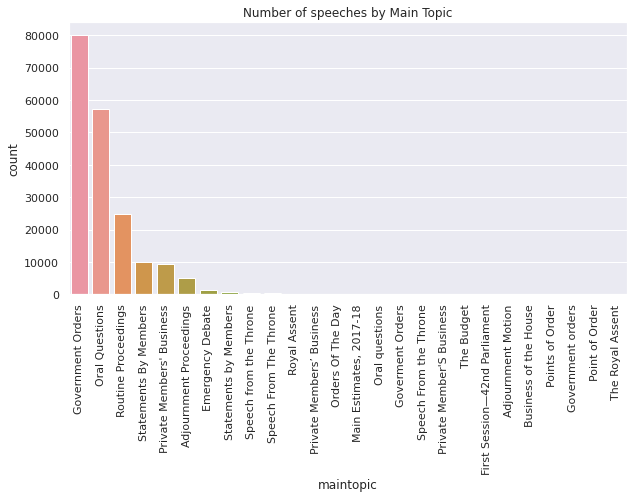

In [0]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(data=combined_csv, x = 'maintopic', order=combined_csv.maintopic.value_counts().index)
plt.xticks(rotation=90)
plt.title("Number of speeches by Main Topic")

The speeches we use include **Statements by Members, Emergency Debates, Routine Proceedings and Government Orders** since they are the ones that should convey the more political bias. We discard the other types of speeches.

In [0]:
# we only keep speeches related to 4 topics (statement by members has 2 spellings)
df_filtered = combined_csv[combined_csv.maintopic.isin(["Statements By Members","Statements by Members","Emergency Debate",
                                                        'Routine Proceedings', 'Government Orders',])]
df_filtered.head(3)

,basepk,hid,speechdate,pid,opid,speakeroldname,speakerposition,maintopic,subtopic,subsubtopic,speechtext,speakerparty,speakerriding,speakername,speakerurl
6,4755138,ca.proc.d.2018-10-04.10287307,2018-10-04,3176068f-62ee-4b2f-aacd-1131201c6db1,214707.0,The Speaker,NaN,Routine Proceedings,Information Commissioner,NaN,I have the honour to lay upon the table the 20...,Liberal,Halifax West,Geoff Regan,http://www.parl.gc.ca/Parliamentarians/en/memb...
7,4755139,ca.proc.d.2018-10-04.10287312,2018-10-04,3176068f-62ee-4b2f-aacd-1131201c6db1,214707.0,The Speaker,NaN,Routine Proceedings,Commissioner of Official Languages,NaN,I have the honour to lay upon the table the an...,Liberal,Halifax West,Geoff Regan,http://www.parl.gc.ca/Parliamentarians/en/memb...
8,4755140,ca.proc.d.2018-10-04.10286897,2018-10-04,eb53bf99-e3d5-44b9-a15e-6c295470cdd4,216052.0,"Hon. Kevin Sorenson (Battle River—Crowfoot, CPC)",NaN,Routine Proceedings,Committees of the House,Public Accounts,"Mr. Speaker, I have the honour to present, in ...",Conservative,Battle River—Crowfoot,Kevin Sorenson,http://www.parl.gc.ca/Parliamentarians/en/memb...


In [0]:
print("Filtered data set shape :", df_filtered.shape)

Filtered data set shape : (116583, 15)


**Focus on our target variable : *speakerparty***

Let's have a look at the distribution of political parties across our newly constructed dataset.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Number of speeches by Political Party')

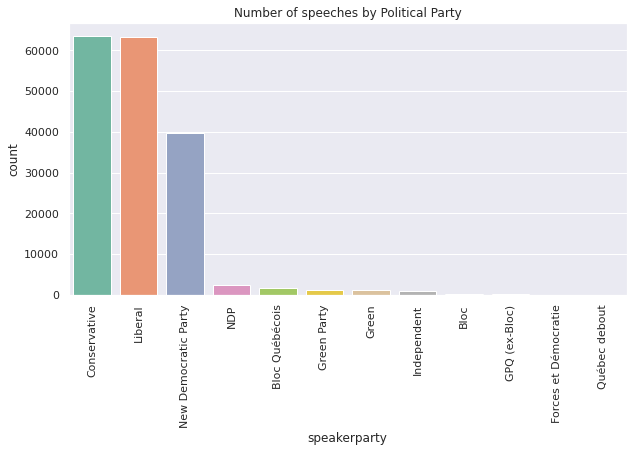

In [0]:
# speaker party is our target variable : we first delete rows for which the variable is missing
df_filtered.dropna(subset=['speakerparty'],inplace=True)

# plot number of speeches by political party
plt.figure(figsize=(10,5))
sns.countplot(data=combined_csv, x = 'speakerparty', order=combined_csv.speakerparty.value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title("Number of speeches by Political Party")

**Keeping the most represented political parties**

As political classes are imbalanced, we decided to keep only the 3 most represented political parties. We are then dealing with a multiclass classification task. 

In [0]:
# Get the list of the top-3 most frequent political parties in speeches 
list_parties = df_filtered.speakerparty.value_counts()[:3].index.tolist()

# filtering dataset according to this list
df_filtered = df_filtered[df_filtered.speakerparty.isin(list_parties)]

print("Number of speeches after keeping the 3 most represented political parties" , df_filtered.shape)

Number of speeches after keeping the 3 most represented political parties (99860, 15)


How many speeches by political party ? 

Conservative            38327
Liberal                 35233
New Democratic Party    26300
Name: speakerparty, dtype: int64 





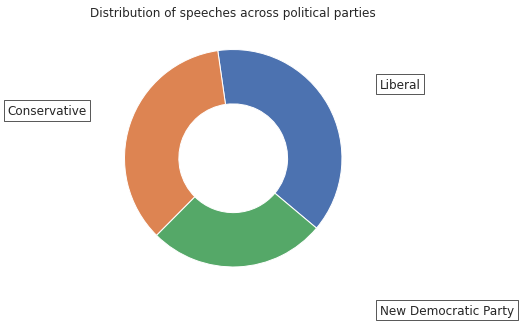

In [0]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(df_filtered.speakerparty.value_counts(), wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(df_filtered.speakerparty.unique().tolist()[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Distribution of speeches across political parties")

#Table of counts of speeches by political partysns.set(style="darkgrid")

print(df_filtered.speakerparty.value_counts(), "\n\n\n")
plt.show()

For our analysis, we keep only the variables :

- `speechtext` (text)
-`speakerparty`  (labels)

In [0]:
# For our analysis, we only keep the following variables : speechtext and	speakerparty
df_filtered = df_filtered[["speechtext", "speakerparty"]]
print("Filtered dataset shape: ", df_filtered.shape)
df_filtered.head()

Filtered dataset shape:  (99860, 2)


,speechtext,speakerparty
6,I have the honour to lay upon the table the 20...,Liberal
7,I have the honour to lay upon the table the an...,Liberal
8,"Mr. Speaker, I have the honour to present, in ...",Conservative
9,"Mr. Speaker, I have the honour to present, in ...",Liberal
10,"moved for leave to introduce Bill C-415, an a...",New Democratic Party


In [0]:
# Show a speech
print("First speech of the sample : \n", df_filtered.speechtext.iloc[0])

First speech of the sample : 
 I have the honour to lay upon the table the 2017-18 annual reports of the Information Commissioner of Canada concerning the Access to Information Act and the Privacy Act. Pursuant to Standing Order 108(3)(h), these reports are deemed permanently referred to the Standing Committee on Access to Information, Privacy and Ethics.


After the different filtering steps, we end up with 99 860 speeches.


>

> ### `2) Corpus statistics`

We herebelow provide different statistics to better grasp the structure of our political corpus.



1. Number of sentences by speech

We use the function `nltk sent_tokenize`  to detect sentences. 

In [0]:
# divide each speech into sentences
df_filtered["speechtext_sent"] = df_filtered.speechtext.apply(lambda x: sent_tokenize(x))

# number of sentences by speech
df_filtered["nb_sentences"] = df_filtered.speechtext_sent.apply(lambda x: len(x))

2. Number of words by speech

In [0]:
df_filtered["nb_words"] = df_filtered.speechtext.str.split().apply(lambda x: len(x))

3. Average number of words by sentence

In [0]:
df_filtered["avg_words_sent"] = df_filtered.nb_words/df_filtered.nb_sentences
df_filtered.head(3)

,speechtext,speakerparty,speechtext_sent,nb_sentences,nb_words,avg_words_sent
6,I have the honour to lay upon the table the 20...,Liberal,[I have the honour to lay upon the table the 2...,2,51,25.5
7,I have the honour to lay upon the table the an...,Liberal,[I have the honour to lay upon the table the a...,2,53,26.5
8,"Mr. Speaker, I have the honour to present, in ...",Conservative,"[Mr. Speaker, I have the honour to present, in...",5,84,16.8


We can now compute the different statistics by political party in order to see if these are balanced.

**Number of speeches by party**

Conservative            38327
Liberal                 35233
New Democratic Party    26300
Name: speakerparty, dtype: int64


Text(0, 0.5, 'Political Party')

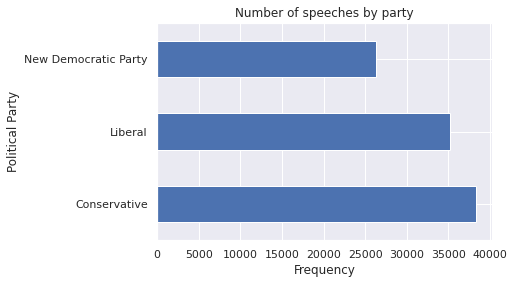

In [0]:
# plot number of speeches by political party
# number of speeches by political party
print(df_filtered.speakerparty.value_counts())

## Barplot to better visualize
fig = df_filtered.speakerparty.value_counts().plot.barh(width=0.5)
fig.set_title('Number of speeches by party')
fig.set_xlabel('Frequency')
fig.set_ylabel('Political Party')

**Average speech length by party in terms of words.**

speakerparty
Conservative            261.090485
Liberal                 210.160361
New Democratic Party    263.408631
Name: nb_words, dtype: float64


Text(0, 0.5, 'Political Party')

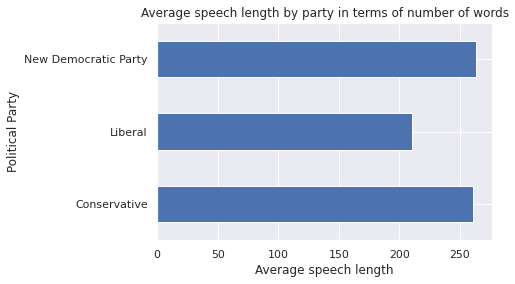

In [0]:
## Avg. speech length by party in terms of words
print(df_filtered.groupby('speakerparty')['nb_words'].mean())

## Barplot to better visualize
fig = df_filtered.groupby('speakerparty')['nb_words'].mean().plot.barh(width=0.5)
fig.set_title('Average speech length by party in terms of number of words')
fig.set_xlabel('Average speech length')
fig.set_ylabel('Political Party')

**Distribution of the number of words per speech**

We first look at the quantiles:

In [0]:
# quantile of words per speech : 10%, 25%, 50%, 75%, 95%
df_filtered.groupby('speakerparty')['nb_words'].quantile([.1, .25, .5, .75, .95, 1])

speakerparty              
Conservative          0.10       18.0
                      0.25       59.0
                      0.50      129.0
                      0.75      190.0
                      0.95     1379.0
                      1.00    12268.0
Liberal               0.10       16.0
                      0.25       53.0
                      0.50      122.0
                      0.75      174.0
                      0.95     1141.4
                      1.00     4920.0
New Democratic Party  0.10       27.0
                      0.25       77.0
                      0.50      140.0
                      0.75      200.0
                      0.95     1341.0
                      1.00     4676.0
Name: nb_words, dtype: float64

Then we look at the distribution function.

Empirical cumulative distribution function (ECDF) of number of words by political party



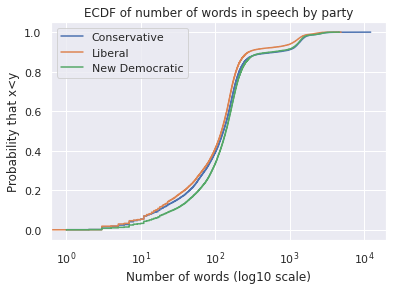

In [0]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

conservative = df_filtered[df_filtered.speakerparty =="Conservative"].nb_words
liberal = df_filtered[df_filtered.speakerparty =="Liberal"].nb_words
newdemocratic = df_filtered[df_filtered.speakerparty =="New Democratic Party"].nb_words

xc, yc = ecdf(conservative)
xl, yl = ecdf(liberal)
xd, yd = ecdf(newdemocratic)
plt.step(x=xc, y=yc, label = "Conservative")
plt.step(x=xl, y=yl, label = "Liberal")
plt.step(x=xd, y=yd, label = "New Democratic")
plt.xscale('log')
plt.title("ECDF of number of words in speech by party")
plt.xlabel("Number of words (log10 scale)")
plt.ylabel("Probability that x<y")
plt.legend()
plt.show()


The empirical cumulative distribution function can be read as follows:
- The 3 parties have similar distribution of words in their speeches.
- The liberal party has sligthly smaller speeches.
- Around 50% of speeches have less than 100 words.
- A significant number of speeches has a high number of words (around 1000 words). Maybe those speeches are different from the others.


Thanks to this analysis, we decide to **remove speeches with less than 50 words and with more than 1500 words**.

In [0]:
#removing speeches with less than 50 words and with more than 1500 words
df_filtered = df_filtered[df_filtered.nb_words > 50]
df_filtered = df_filtered[df_filtered.nb_words < 1500]
print("Number of speeches after filtering by the number of words", df_filtered.shape)

Number of speeches after filtering by the number of words (75844, 6)


Let's check that the balancing of our parties has not changed much.

Conservative            28705
Liberal                 26092
New Democratic Party    21047
Name: speakerparty, dtype: int64


Text(0, 0.5, 'Political Party')

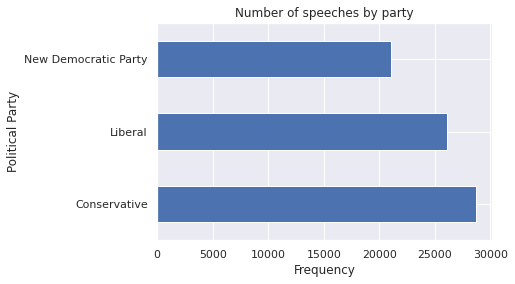

In [0]:
# number of speeches by political party
print(df_filtered.speakerparty.value_counts())

## Barplot to better visualize
fig = df_filtered.speakerparty.value_counts().plot.barh(width=0.5)
fig.set_title('Number of speeches by party')
fig.set_xlabel('Frequency')
fig.set_ylabel('Political Party')

**Distribution of the number of sentences by political party**

In [0]:
# number of sentences by political party
df_filtered.groupby('speakerparty')['nb_sentences'].sum()

speakerparty
Conservative            348842
Liberal                 282298
New Democratic Party    263344
Name: nb_sentences, dtype: int64

Text(0, 0.5, 'Political Party')

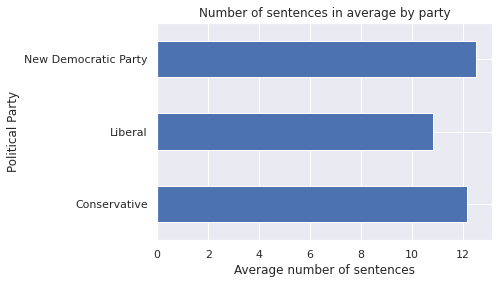

In [0]:
# number of sentences in average by politcal party
df_filtered.groupby('speakerparty')['nb_sentences'].mean()

## Barplot to better visualize
fig = df_filtered.groupby('speakerparty')['nb_sentences'].mean().plot.barh(width=0.5)
fig.set_title('Number of sentences in average by party')
fig.set_xlabel('Average number of sentences')
fig.set_ylabel('Political Party')

In [0]:
# Avg. speech length by party in terms of sentences
df_filtered.groupby('speakerparty')['avg_words_sent'].mean()

speakerparty
Conservative            25.631540
Liberal                 25.765918
New Democratic Party    26.898301
Name: avg_words_sent, dtype: float64

ECDF of the number of sentences per speech by political party:

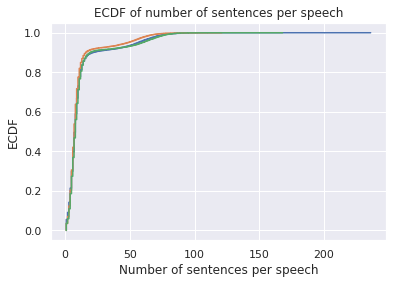

In [0]:
# ECDF of number of sentences per speech
conservative = df_filtered[df_filtered.speakerparty =="Conservative"].nb_sentences
liberal = df_filtered[df_filtered.speakerparty =="Liberal"].nb_sentences
newdemocratic = df_filtered[df_filtered.speakerparty =="New Democratic Party"].nb_sentences

xc, yc = ecdf(conservative)
xl, yl = ecdf(liberal)
xd, yd = ecdf(newdemocratic)
plt.step(x=xc, y=yc)
plt.step(x=xl, y=yl)
plt.step(x=xd, y=yd)
plt.title("ECDF of number of sentences per speech")
plt.xlabel("Number of sentences per speech")
plt.ylabel("ECDF")

#plt.xscale('log')
plt.show()

The speeches have similar sentence distributions across parties. 

In [0]:
df_filtered.shape

(75844, 6)

After the different filtering steps, we end up with **75 884 speeches**.


>

> ### `3) Who says what? : A quick analysis of speeches by political party`

We here want to analyse the speeches made by each political party to see whether some words or topics are more used by a party than antoher. In order to do so, we popose to visualize a word cloud for each political party based on the TF-IDF weights.



We first clean speeches : tokenization, removal of punctuation, stopwords, and numeric information, lemmatization, transformation to lowercase.



In [0]:
stemmer = PorterStemmer()
spacy_en = spacy.load('en_core_web_sm')
def tokenizer_word_spacy(text):
   tokens = [token.lemma_.lower() for token in spacy_en.tokenizer(text) if not token.is_stop | token.is_punct | token.is_space | token.is_digit ]  
   tokens = [tok for tok in tokens if tok not in ["speaker", "mr.", "mrs", "madam", "hon", "member", "mr"]]
   return(tuple(tokens))

We herebelow define a function in order to plot word clouds based on tf-Idf weights for each political party. This will enable us to see which are the trendy topics for each party.

In [0]:
# we first split data by political party
df_con = df_filtered[df_filtered.speakerparty =="Conservative"]
df_lib = df_filtered[df_filtered.speakerparty =="Liberal"]
df_ndp = df_filtered[df_filtered.speakerparty =="New Democratic Party"]
print(df_con.shape, df_lib.shape, df_ndp.shape)

# we then create a function that construct word clouds base on tf-idf weights
def word_cloud(data):
    vectorizer = TfidfVectorizer(tokenizer = tokenizer_word_spacy, ngram_range = ((2,2)))
    tdm = vectorizer.fit_transform(data['speechtext'])
    freqs = dict([(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()])
    w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=50).fit_words(freqs)
    plt.imshow(w)
    plt.axis('off')
    plt.show()

(28705, 6) (26092, 6) (21047, 6)


For each political party, we propose to randomny draw 1000 speeches in order to plot the word clouds otherwise the commands are very long to run.


Word cloud for Conservative party


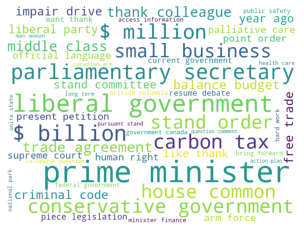

None


In [0]:
np.random.seed(123)
con_subset = df_con.sample(n=1000)       
print("Word cloud for Conservative party")
print(word_cloud(con_subset))

Word cloud for Liberal party


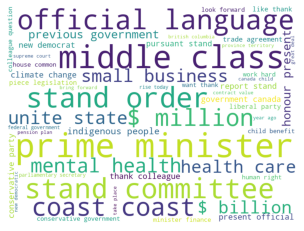

None


In [0]:
np.random.seed(123)
lib_subset = df_lib.sample(n=1000)       
print("Word cloud for Liberal party")
print(word_cloud(lib_subset))

Word cloud for New Democratic Party


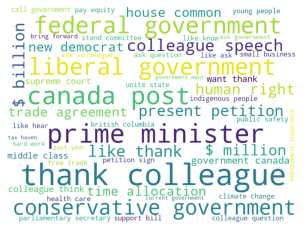

None


In [0]:
np.random.seed(123)
ndp_subset = df_ndp.sample(n=1000) 
print("Word cloud for New Democratic Party")
print(word_cloud(ndp_subset))

We got rid of some very common words used by all parties (including "Mr speaker", an expression that introduces most speeches or "hon member") that were polluting our word clouds.  This has enabled us to detect a vocubalary that was more specific to each political party.

* For instance, the Conservative party widely uses a vocabulary related to trade : "businesses", "trade agreement", "balange budget" etc,. 

* The Liberal party is associated with more social phrases related to the "middle class", "healthcare" and "mental health". 

* The New Democratic Party is associated with phrases like "trade agreement" and "human right". 

* We also notice that the references to liberal and conservative governments are very frequent in Conservative and NDP speeches whereas Liberal speeches do not refer to them as much.


> ### `4) Sentiment detection`

We adopt the preprocessing approach of the paper *Political Ideology Detection Using Recursive Neural Networks* by Mohit Iyyer, Peter Enns, Jordan Boyd-Graber and Philip Resnik (https://www.researchgate.net/publication/270877818_Political_Ideology_Detection_Using_Recursive_Neural_Networks)


In this paper, they filtered speeches that contained the most emotional and political content. This comes with the idea that in a speech, not all sentences convey the same amount of information. In particular, neutral sentences which are emotionless increase the noise and do not provide relevant information for prediction. 


We are thus now focusing on filtering sentences within speeches and keeping the sentences that convey the most emotional content. We want to keep the most relevant sentences in each speech for our analysis. According to the authors, this increases the accuracy of the model. We want to test this hypothesis by running our models with the full speeches and with the filtered speeches. 

**In order to do so, we provide a sentiment score for each speech at the sentence level.**

We first define a function that will assign a **sentiment score** to each sentence of a speech. We use the `TextBlob` module and the function`sentiment.polarity`. It gives an emotional score between -1 and 1. 

We made the choice of keeping the 5 sentences with the highest absolute scores in each speech.


We first define a function that will assign a sentiment score to each sentence of a speech.

In [0]:
# definition of a function that selects for each speech the sentences with the highest sentiment score
# the argument of the function is a speech
def to_keep(t):
  polarity = [TextBlob(x).sentiment.polarity for x in t]

  # take the absolute value since polarity belongs to [-1,1] : -1 for negative sentiments 
  # and +1 for positive ones
  polarity =  [abs(ele) for ele in polarity] 

  # for each speech, we keep the 5 sentences with the highest scores
  l = sorted(range(len(polarity)), key=lambda i: polarity[i])[-5:]

  # sentences to keep
  sent_kept = [t[i] for i in l]
  
  # then we return the list of the sentence indexes of interest
  return(sent_kept)


print("For instance, for the 9th speech, we keep the following sentences: ", to_keep(df_filtered.speechtext_sent.iloc[8]))

For instance, for the 9th speech, we keep the following sentences:  ['Therefore, the petitioners call upon the Government of Canada to enact my motion, Motion No.', '166, to create a committee to study and propose a plan for postal banking under the Canada Post Corporation.', 'Nearly two million Canadians desperately need an alternative to payday lenders, whose crippling and predatory rates affect the poor, marginalized, rural and indigenous communities most.', 'There are 3,800 Canada Post outlets already in rural areas, where there are few or even no banks at all.', 'The first is a petition in support of postal banking.']


In [0]:
# Creation of a new column with the filtered speeches
# this cell takes a while to execute
df_filtered['speechtextFiltered'] = df_filtered.speechtext_sent.apply(lambda t: to_keep(t))
df_filtered.head(3)

,speechtext,speakerparty,speechtext_sent,nb_sentences,nb_words,avg_words_sent,speechtextFiltered
6,I have the honour to lay upon the table the 20...,Liberal,[I have the honour to lay upon the table the 2...,2,51,25.5,[I have the honour to lay upon the table the 2...
7,I have the honour to lay upon the table the an...,Liberal,[I have the honour to lay upon the table the a...,2,53,26.5,[I have the honour to lay upon the table the a...
8,"Mr. Speaker, I have the honour to present, in ...",Conservative,"[Mr. Speaker, I have the honour to present, in...",5,84,16.8,"[Mr. Speaker, I have the honour to present, in..."


We can now look again at our main corpus statistics to see if this last filtering step considerably changed them.

In [0]:
# nb of sentences by filtered speech
df_filtered["nb_sentencesF"] = df_filtered.speechtextFiltered.apply(lambda x: len(x))

# We 1st need to unsplit the "speechtextFiltered" column
df_filtered["speechtextFiltered_un"] = df_filtered.speechtextFiltered.apply(lambda x : TreebankWordDetokenizer().detokenize(x))

# let's check
df_filtered["speechtextFiltered_un"].iloc[0]

'I have the honour to lay upon the table the 2017-18 annual reports of the Information Commissioner of Canada concerning the Access to Information Act and the Privacy Act. Pursuant to Standing Order 108(3)(h), these reports are deemed permanently referred to the Standing Committee on Access to Information, Privacy and Ethics.'

In [0]:
# nb of words in filtered speeches
df_filtered["nb_wordsF"] = df_filtered.speechtextFiltered_un.str.split().apply(lambda x: len(x))

# avg number of words by sentence in filtered speech
df_filtered["avg_words_sentF"] = df_filtered.nb_wordsF/df_filtered.nb_sentencesF

In [0]:
## Avg. speech length by party in terms of words
df_filtered.groupby('speakerparty')['nb_wordsF'].mean()

speakerparty
Conservative            100.634210
Liberal                 103.173655
New Democratic Party    103.828052
Name: nb_wordsF, dtype: float64

We go from an average sppech length of 260 words in average to 100 after the filtering.

Let's look at the distribution of the number of words per filtered speech

In [0]:
# Quantiles of number of words per filtered speech : 10%, 25%, 50%, 75%, 95%
df_filtered.groupby('speakerparty')['nb_wordsF'].quantile([.1, .25, .5, .75, .95, 1])

speakerparty              
Conservative          0.10      62.0
                      0.25      77.0
                      0.50      97.0
                      0.75     119.0
                      0.95     156.0
                      1.00    1062.0
Liberal               0.10      63.0
                      0.25      79.0
                      0.50      99.0
                      0.75     120.0
                      0.95     156.0
                      1.00    1406.0
New Democratic Party  0.10      64.0
                      0.25      79.0
                      0.50      97.0
                      0.75     119.0
                      0.95     159.0
                      1.00    1484.0
Name: nb_wordsF, dtype: float64

In [0]:
# number of sentences in average by politcal party
df_filtered.groupby('speakerparty')['nb_sentencesF'].mean()

speakerparty
Conservative            4.498206
Liberal                 4.567262
New Democratic Party    4.609255
Name: nb_sentencesF, dtype: float64

We have less than 5 sentences in average because some speeches have less than 5 sentences so filtering the sentences did not change anything for them. Otherwise, all the other filtered speeches have been reduced to 5 sentences.

In [0]:
# Avg. speech length by party in terms of words
df_filtered.groupby('speakerparty')['avg_words_sentF'].mean()

speakerparty
Conservative            26.611617
Liberal                 26.739268
New Democratic Party    27.940392
Name: avg_words_sentF, dtype: float64

**We can now save the final datset we will be using for the modelling part.**




In [0]:
df_filtered = df_filtered[["speechtext", "speechtextFiltered_un", "speakerparty"]]
#df_filtered.to_csv("df_multiclass.csv", index=False)

In [0]:
df_filtered.shape

(75844, 3)

>

> ### `5) Train, Test and Validation sets`


**We create train, test and validation sets to make sure we use the same all along the modelling part.**

* For baseline models, we only need train and test sets, so we split the initial data into train (0.8) and test (0.2).
* For sequence models, we also use a validation set. It is obtained from splitting the test set into a test (0.5) and a validation (0.5) set.
* In this way we make sure that we are training our models on the same sets.

Also the splits are done on a stratified basis in order to make sure that all classes are represented in all sets.

In [0]:
# Train / Test split
# the parameter "stratify=y" allows us to make sure our sets are balanced
train, test = train_test_split(df_filtered, test_size=0.2, random_state=42, stratify=df_filtered.speakerparty)
print("Train shape:", train.shape, "\nTest shape:", test.shape)

Train shape: (60675, 3) 
Test shape: (15169, 3)


In [0]:
# Split again test into test2 and validation sets
test2, validation = train_test_split(test, test_size=0.5, random_state=42, stratify=test.speakerparty)
print("Test2 shape:", test2.shape, "\nValidation shape:", validation.shape)

Test2 shape: (7584, 3) 
Validation shape: (7585, 3)


In [0]:
# save all the datasets
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
test2.to_csv("test2.csv", index=False)
validation.to_csv("validation.csv", index=False)

> 





## **III. BASELINE MODELS**

We focus on 3 baseline models in order to classify speeches. We recall that our features consist in words embeddings for each speech and that our target variable is the speaker party.
We use different learning classifiers on  : 

1.   Bag Of Words (BoW) based on unigrams
2.   TF-IDF vectors
3.   Doc2Vec embeddings.


We use the 2 versions of our data : the non-filtered version and the filtered version and we compare performances. 

In [0]:
# df_filtered = pd.read_csv("df_multiclass.csv")
# train=pd.read_csv("train.csv")
# testpd.read_csv("test.csv")
# test2=pd.read_csv("test2.csv")
# validation=pd.read_csv("validation.csv")

> ### `1) Bag of Words approach`

https://www.linkedin.com/pulse/text-classification-using-bag-words-approach-nltk-scikit-rajendran
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html


We herebelow implement a function in order to clean speeches :

*   tokenization
*   removal of stop-words, punctuation, spaces, numbers
*   lemmatization

Compared to the function we used for word clouds, here, we do not remove the most common words.

In [0]:
def tokenizer_word_spacy(text):
   tokens = [token.lemma_.lower() for token in spacy_en.tokenizer(text) if not token.is_stop | token.is_punct | token.is_space | token.is_digit] 
   return(tuple(tokens))

In [0]:
def tokens_cleaning(data):
  data["full_tokens"] = data["speechtext"].apply(lambda x : tokenizer_word_spacy(x))
  data["full_joined_tokens"] = data.full_tokens.apply(lambda x : " ".join(x))
  data["filt_tokens"] = data["speechtextFiltered_un"].apply(lambda x : tokenizer_word_spacy(x))
  data["filt_joined_tokens"] = data.filt_tokens.apply(lambda x : " ".join(x))
  return(data)

In [0]:
tokens_cleaning(df_filtered.head(5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,speechtext,speechtextFiltered_un,speakerparty,full_tokens,full_joined_tokens,filt_tokens,filt_joined_tokens
6,I have the honour to lay upon the table the 20...,I have the honour to lay upon the table the 20...,Liberal,"(honour, lie, table, annual, report, informati...",honour lie table annual report information com...,"(honour, lie, table, annual, report, informati...",honour lie table annual report information com...
7,I have the honour to lay upon the table the an...,I have the honour to lay upon the table the an...,Liberal,"(honour, lie, table, annual, report, access, i...",honour lie table annual report access informat...,"(honour, lie, table, annual, report, access, i...",honour lie table annual report access informat...
8,"Mr. Speaker, I have the honour to present, in ...","Mr. Speaker, I have the honour to present, in ...",Conservative,"(mr., speaker, honour, present, official, lang...",mr. speaker honour present official language 5...,"(mr., speaker, honour, present, official, lang...",mr. speaker honour present official language 5...
9,"Mr. Speaker, I have the honour to present, in ...","Pursuant to Standing Order 109, the committee ...",Liberal,"(mr., speaker, honour, present, official, lang...",mr. speaker honour present official language 1...,"(pursuant, standing, order, committee, request...",pursuant standing order committee request gove...
10,"moved for leave to introduce Bill C-415, an a...","In Halifax, they were five times as likely to ...",New Democratic Party,"(move, leave, introduce, bill, c-415, act, est...",move leave introduce bill c-415 act establish ...,"(halifax, time, likely, arrest, regina, happen...",halifax time likely arrest regina happen time ...


We can now create a feature matrix

In [0]:
# Create our feature matrix
def feature_matrix(data, text_name):
  data = tokens_cleaning(data)
  matrix = CountVectorizer(max_features=1000)
  if text_name == "speechtext":
    X = matrix.fit_transform(data["full_joined_tokens"]).toarray()
    y = data["speakerparty"]
  else :
    X = matrix.fit_transform(data["filt_joined_tokens"]).toarray()
    y = data["speakerparty"] 
  print(X.shape)
  print(y.shape)
  return(X, y)

In [0]:
X_full, y_full = feature_matrix(df_filtered, "speechtext")

(75844, 1000)
(75844,)


In [0]:
X_fil, y_fil = feature_matrix(df_filtered, "speechtextFiltered_un")

(75844, 1000)
(75844,)


Train/test split of the feature matrix for full and filtered speeches.

In [0]:
# we use the same random_state and the same test size we chose to define our train and test sets
# we do not directly use the train and the test sets we create since we need to build a vocabulary on the whole data
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42, test_size=0.2, stratify=y_full) 
X_train_fil, X_test_fil, y_train_fil, y_test_fil = train_test_split(X_fil, y_fil, random_state=42, test_size=0.2, stratify=y_fil) 

In [0]:
# verifications
print(y_test.tolist() == y_test_fil.tolist())
print(y_train.tolist() == y_train_fil.tolist())
print(y_full.tolist() == y_fil.tolist())

True
True
True


In [0]:
# The train set consists in the filtered speeches but the test should consist in the full speeches so we overwrite the X_test_fil matrix.
X_test_fil = X_test
# we will only be using X_test and y_test when evaluating on test sets to not bring confusion


**Using a MultinomialNB classifier**

FULL SPEECHES

In [0]:
# FULL SPEECHES
classifierNB = MultinomialNB().fit(X_train, y_train)

# Predict class
y_predNB = classifierNB.predict(X_test)

# Evaluation
cr = classification_report(y_test, y_predNB)
accuracy_NB_Bow = accuracy_score(y_test, y_predNB)
fscore_NB_Bow = f1_score(y_test, y_predNB, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_NB_Bow)
print("F1-score:", fscore_NB_Bow)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.62      0.50      0.55      5741
             Liberal       0.59      0.61      0.60      5219
New Democratic Party       0.54      0.66      0.59      4209

            accuracy                           0.58     15169
           macro avg       0.58      0.59      0.58     15169
        weighted avg       0.59      0.58      0.58     15169

Accuracy: 0.5801964532929
F1-score: 0.5789131925361382


FILTERED SPEECHES

In [0]:
# FILTERED SPEECHES
classifierNBfil = MultinomialNB().fit(X_train_fil, y_train)

# Predict class
yfil_predNB = classifierNBfil.predict(X_test)

# Evaluation
cr = classification_report(y_test, yfil_predNB)
accuracyfil_NB_Bow = accuracy_score(y_test, yfil_predNB)
fscorefil_NB_Bow = f1_score(y_test, yfil_predNB, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracyfil_NB_Bow)
print("F1-score:", fscorefil_NB_Bow)

Confusion matrix
 [[2381 1926 1434]
 [1870 1839 1510]
 [1440 1467 1302]]
Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.42      0.41      0.42      5741
             Liberal       0.35      0.35      0.35      5219
New Democratic Party       0.31      0.31      0.31      4209

            accuracy                           0.36     15169
           macro avg       0.36      0.36      0.36     15169
        weighted avg       0.36      0.36      0.36     15169

Accuracy: 0.3640319071791153
F1-score: 0.36419200507012944


**Using a SVM classifier**

FULL SPEECHES

In [0]:
# FULL SPEECHES
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train, y_train)

# Predict class
y_predSvm = clf_svm.predict(X_test)

# Evaluation
cr = classification_report(y_test, y_predSvm)
accuracy_SVM_Bow = accuracy_score(y_test, y_predSvm)
fscore_SVM_Bow = f1_score(y_test, y_predSvm, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_SVM_Bow)
print("F1-score:", fscore_SVM_Bow)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.65      0.54      0.59      5741
             Liberal       0.58      0.71      0.64      5219
New Democratic Party       0.62      0.58      0.60      4209

            accuracy                           0.61     15169
           macro avg       0.62      0.61      0.61     15169
        weighted avg       0.62      0.61      0.61     15169

Accuracy: 0.6134880348078318
F1-score: 0.6117354571948331




FILTERED SPEECHES

In [0]:
# FILTERED SPEECHES

clf_svmfil = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_fil, y_train)

# Predict class
yfil_predSvm = clf_svmfil.predict(X_test)

# Evaluation
cr = classification_report(y_test, yfil_predSvm)
accuracyfil_SVM_Bow = accuracy_score(y_test, yfil_predSvm)
fscorefil_SVM_Bow = f1_score(y_test, yfil_predSvm, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracyfil_SVM_Bow)
print("F1-score:", fscorefil_SVM_Bow)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.42      0.32      0.36      5741
             Liberal       0.35      0.36      0.36      5219
New Democratic Party       0.32      0.42      0.37      4209

            accuracy                           0.36     15169
           macro avg       0.37      0.37      0.36     15169
        weighted avg       0.37      0.36      0.36     15169

Accuracy: 0.36106533060847784
F1-score: 0.3609026927355428


>

> ### `2) TF-IDF approach`

Instead of using occurences to get document representation, it is theoretically preferable to look at frequencies especially in case of length-varying documents.

FULL SPEECHES

In [0]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
print(X_train_tfidf.shape)

X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_test_tfidf.shape)

(60675, 1000)
(15169, 1000)


FILTERED SPEECHES

In [0]:
# FILTERED SPEECHES
tfidf_transformer = TfidfTransformer()

Xfil_train_tfidf = tfidf_transformer.fit_transform(X_train_fil)
print(Xfil_train_tfidf.shape)

(60675, 1000)


**MultinomialNB classifier**

FULL SPEECHES

In [0]:
# FULL SPEECHES
# Predict class
classifierNB_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)
predNB_tfidf = classifierNB_tfidf.predict(X_test_tfidf)

# Evaluation
cr = classification_report(y_test, predNB_tfidf)
accuracy_NB_tfidf = accuracy_score(predNB_tfidf, y_test)
fscore_NB_tfidf = f1_score(y_test, predNB_tfidf, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_NB_tfidf)
print("F1-score:", fscore_NB_tfidf)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.55      0.70      0.61      5741
             Liberal       0.60      0.61      0.60      5219
New Democratic Party       0.68      0.42      0.52      4209

            accuracy                           0.59     15169
           macro avg       0.61      0.58      0.58     15169
        weighted avg       0.60      0.59      0.59     15169

Accuracy: 0.5902828136330674
F1-score: 0.5854826606339679


FILTERED SPEECHES

In [0]:
# FILTERED SPEECHES
# Predict class
classifierNB_tfidffil = MultinomialNB().fit(Xfil_train_tfidf, y_train)
predNB_tfidffil = classifierNB_tfidffil.predict(X_test_tfidf)

# Evaluation
accuracy_NB_tfidffil = accuracy_score(predNB_tfidffil, y_test)
fscore_NB_tfidffil = f1_score(y_test, predNB_tfidffil, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_NB_tfidffil)
print("F1-score:", fscore_NB_tfidffil)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.55      0.70      0.61      5741
             Liberal       0.60      0.61      0.60      5219
New Democratic Party       0.68      0.42      0.52      4209

            accuracy                           0.59     15169
           macro avg       0.61      0.58      0.58     15169
        weighted avg       0.60      0.59      0.59     15169

Accuracy: 0.38011734458434965
F1-score: 0.34376516296338444


**SVM Classifier**

FULL SPEECHES

In [0]:
# FULL SPEECHES
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(X_train_tfidf, y_train)

# Predict class
predSVM_tfidf = clf_svm.predict(X_test_tfidf)

# Evaluation
cr = classification_report(y_test, predSVM_tfidf)
accuracy_SVM_tfidf = accuracy_score(predSVM_tfidf, y_test)
fscore_SVM_tfidf = f1_score(y_test, predSVM_tfidf, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_SVM_tfidf)
print("F1-score:", fscore_SVM_tfidf)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.61      0.61      0.61      5741
             Liberal       0.60      0.69      0.64      5219
New Democratic Party       0.65      0.53      0.58      4209

            accuracy                           0.61     15169
           macro avg       0.62      0.61      0.61     15169
        weighted avg       0.62      0.61      0.61     15169

Accuracy: 0.6149383611312546
F1-score: 0.6134742584813758


FILTERED SPEECHES

In [0]:
# FILTERED SPEECHES
clf_svmfil = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(Xfil_train_tfidf, y_train)

# Predict class
predSVM_tfidffil = clf_svmfil.predict(X_test_tfidf)

# Evaluation
accuracy_SVM_tfidffil = accuracy_score(predSVM_tfidffil, y_test)
fscore_SVM_tfidffil = f1_score(y_test, predSVM_tfidffil, average='weighted')
cm_SVM_tfidffil = confusion_matrix(y_test, predSVM_tfidffil)
print("Classification report: \n", cr)
print("Accuracy:", accuracy_SVM_tfidffil)
print("F1-score:", fscore_SVM_tfidffil)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.61      0.61      0.61      5741
             Liberal       0.60      0.69      0.64      5219
New Democratic Party       0.65      0.53      0.58      4209

            accuracy                           0.61     15169
           macro avg       0.62      0.61      0.61     15169
        weighted avg       0.62      0.61      0.61     15169

Accuracy: 0.3819632144505241
F1-score: 0.3765120506840488


Using tf-idf vectors does not seem to help predicted better political classes.

>

> ### `3) Doc2Vec approach`

We propose to use Doc2Vec as it allows to take into account semantics and position of words in a document. 
It consists in an unsupervised algorithm that outputs feature vectors of a given fixed length for documents.

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d


We first need to create tagged documents.

In [0]:
te = tokens_cleaning(test)
tr = tokens_cleaning(train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# creation of tagged document for fitting Doc2Vec
test_tagged = te.apply(
    lambda r: TaggedDocument(words=r["full_tokens"], tags=[r["speakerparty"]]), axis=1)
train_tagged = tr.apply(
    lambda r: TaggedDocument(words=r["full_tokens"], tags=[r["speakerparty"]]), axis=1)
train_tagged_filtered = tr.apply(
    lambda r: TaggedDocument(words=r["filt_tokens"], tags=[r["speakerparty"]]), axis=1)

print("Example of tagged document s: \n", test_tagged.values[0:2])

Example of tagged document s: 
 [TaggedDocument(words=('mr.', 'speaker', 'sure', 'member', 'government', 'minister', 'newfoundland', 'labrador', 'think', 'great', 'minister', 'represent', 'province', 'legislation', 'money', 'gain', 'illegal', 'fundraiser', 'pay', 'similar', 'vein', 'trip', 'take', 'island', 'ethics', 'commissioner', 'find', 'illegal', '$', '215,000', 'pay', 'taxpayer'), tags=['Conservative'])
 TaggedDocument(words=('mr.', 'speaker', 'hon', 'member', 'rightly', 'raise', 'issue', 'indigenous', 'incarceration', 'honour', 'serve', 'public', 'safety', 'national', 'security', 'committee', 'year', 'study', 'issue', 'sure', 'aware', 'ask', 'hon', 'member', 'review', 'section', 'propose', 'bill', 'bill', 'c-83', 'focus', 'bring', 'life', 'call', 'landmark', 'decision', 'supreme', 'court', 'gladue', 'decision', 'year', 'ago', 'incredible', 'step', 'forward', 'positive', 'step', 'forward', 'canadian', 'concern', 'indigenous', 'incarceration', 'end', 'line', 'begin', 'new', 'open'

Instantiate the model and Building the vocabulary


In [0]:
from tqdm import tqdm
import multiprocessing
cores = multiprocessing.cpu_count()

# Model parameters 
# dm=0 – distributed bag of words (PV-DBOW) 
# vector_size – Dimensionality of the feature vectors
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# hs – If 1, hierarchical softmax will be used for model training. If set to 0, and negative is non-zero, negative sampling will be used.
# negative – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

# full model
model_dbow = Doc2Vec(dm=0, vector_size=250, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

# filtered model
filtered_model_dbow = Doc2Vec(dm=0, vector_size=250, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
filtered_model_dbow.build_vocab([x for x in tqdm(train_tagged_filtered.values)])


100%|██████████| 60675/60675 [00:00<00:00, 2380162.88it/s]


Training the model

In [0]:
from sklearn import utils
# on full speeches
for epoch in range(20):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha = model_dbow.alpha - 0.002
    model_dbow.min_alpha = model_dbow.alpha

# on filtered speeches
for epoch in range(20):
    filtered_model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged_filtered.values)]), total_examples=len(train_tagged_filtered.values), epochs=1)
    filtered_model_dbow.alpha = filtered_model_dbow.alpha - 0.002
    filtered_model_dbow.min_alpha = filtered_model_dbow.alpha


100%|██████████| 60675/60675 [00:00<00:00, 2959867.36it/s]


In [0]:
#building final vectors
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
ytrain, Xtrain = vec_for_learning(model_dbow, train_tagged)
ytrain_filtered, Xtrain_filtered = vec_for_learning(filtered_model_dbow, train_tagged_filtered)
ytest, Xtest = vec_for_learning(model_dbow, test_tagged)

In [0]:
#vérification
ytrain_filtered==ytrain

True

**Gaussian NB Classifier**

As we have negative features, we here use a Gaussian NB classifier and not a Multinomial classifier as we previously did.

FULL SPEECHES

In [0]:
from sklearn.naive_bayes import GaussianNB
classifierNB = GaussianNB().fit(Xtrain, ytrain)

# Predict
y_pred = classifierNB.predict(Xtest)

# Evaluation
cr = classification_report(ytest, y_pred)
accuracy_NB_dbow = accuracy_score(y_pred, ytest)
fscore_NB_dbow = f1_score(ytest, y_pred, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_NB_dbow)
print("F1-score:", fscore_NB_dbow)

Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.40      0.35      0.37      5741
             Liberal       0.38      0.41      0.40      5219
New Democratic Party       0.32      0.34      0.33      4209

            accuracy                           0.37     15169
           macro avg       0.37      0.37      0.36     15169
        weighted avg       0.37      0.37      0.37     15169

Accuracy: 0.3674599512162964
F1-score: 0.36757040453178835


FILTERED SPEECHES

In [0]:
classifierNB = GaussianNB().fit(Xtrain_filtered, ytrain)

# Predict
y_pred = classifierNB.predict(Xtest)

# Evaluation
cr = classification_report(ytest, y_pred)
accuracy_NB_dbow_fil = accuracy_score(y_pred, ytest)
fscore_NB_dbow_fil = f1_score(ytest, y_pred, average='weighted')
cm = confusion_matrix(ytest, y_pred)
print("Confusion matrix: \n", cm)
print("Classification report: \n", cr)
print("Accuracy:", accuracy_NB_dbow_fil)
print("F1-score:", fscore_NB_dbow_fil)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix: 
 [[  14    0 5727]
 [   6    0 5213]
 [   3    0 4206]]
Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.61      0.00      0.00      5741
             Liberal       0.00      0.00      0.00      5219
New Democratic Party       0.28      1.00      0.43      4209

            accuracy                           0.28     15169
           macro avg       0.30      0.33      0.15     15169
        weighted avg       0.31      0.28      0.12     15169

Accuracy: 0.2781989584020041
F1-score: 0.12243316025208287


We notice that no speech is predicted as Liberal when we train the model on filtered speeches.

**SVM Classifier**

FULL SPEECHES

In [0]:
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(Xtrain, ytrain)

# Predict
y_pred = clf_svm.predict(Xtest)

# Evaluation
cr = classification_report(y_pred, ytest)
accuracy_SVM_dbow = accuracy_score(y_pred, ytest)
fscore_SVM_dbow = f1_score(ytest, y_pred, average='weighted')
cm = confusion_matrix(ytest, y_pred)
print("Confusion matrix: \n", cm)
print("Classification report: \n", cr)
print("Accuracy:", accuracy_SVM_dbow)
print("F1-score:", fscore_SVM_dbow)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix: 
 [[2124    0 3617]
 [1758    0 3461]
 [1373    0 2836]]
Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.37      0.40      0.39      5255
             Liberal       0.00      0.00      0.00         0
New Democratic Party       0.67      0.29      0.40      9914

            accuracy                           0.33     15169
           macro avg       0.35      0.23      0.26     15169
        weighted avg       0.57      0.33      0.40     15169

Accuracy: 0.3269826620080427
F1-score: 0.25764857783898326


FILTERED SPEECHES

In [0]:
clf_svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(Xtrain_filtered, ytrain)

# Predict
y_pred = clf_svm.predict(Xtest)

# Evaluation
cr = classification_report(y_pred, ytest)
accuracy_SVM_dbow_fil = accuracy_score(y_pred, ytest)
fscore_SVM_dbow_fil = f1_score(ytest, y_pred, average='weighted')
print("Classification report: \n", cr)
print("Accuracy:", accuracy_SVM_dbow_fil)
print("F1-score:", fscore_SVM_dbow_fil)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report: 
                       precision    recall  f1-score   support

        Conservative       0.00      0.00      0.00         0
             Liberal       0.00      0.00      0.00         0
New Democratic Party       1.00      0.28      0.43     15169

            accuracy                           0.28     15169
           macro avg       0.33      0.09      0.14     15169
        weighted avg       1.00      0.28      0.43     15169

Accuracy: 0.2774737952402927
F1-score: 0.12053743463374877


When training SVM on filtered speeches, all the speeches of the test set are classified as NDP.

We notice the poor performance of the classifiers when trained on Doc2Vec embeddings.

>


> ### **`Summary of the results with Baseline Models`**

**When models are trained on full speeches :**

In [0]:
d = ({"Method" : ["BoW + NB", "BoW + SVM", "Tf-Idf + NB", "Tf-Idf + SVM", "DBOW + NB", "DBOW + SVM"],
     "Accuracy" : [accuracy_NB_Bow, accuracy_SVM_Bow, accuracy_NB_tfidf, accuracy_SVM_tfidf, accuracy_NB_dbow , accuracy_SVM_dbow ], 
     'Weighted F1-score': [fscore_NB_Bow, fscore_SVM_Bow, fscore_NB_tfidf, fscore_SVM_tfidf, fscore_NB_dbow , fscore_SVM_dbow ]})
res = pd.DataFrame(d)
res

,Method,Accuracy,Weighted F1-score
0,BoW + NB,0.580196,0.578913
1,BoW + SVM,0.613488,0.611735
2,Tf-Idf + NB,0.590283,0.585483
3,Tf-Idf + SVM,0.614938,0.613474
4,DBOW + NB,0.367460,0.367570
5,DBOW + SVM,0.326983,0.257649


**When models are trained on filtered speeches :**

In [0]:
dFil = ({"Method" : ["BoW + NB", "BoW + SVM", "Tf-Idf + NB", "Tf-Idf + SVM", "DBOW + NB", "DBOW + SVM"],
     "Accuracy" : [accuracyfil_NB_Bow, accuracyfil_SVM_Bow, accuracy_NB_tfidffil, accuracy_SVM_tfidffil, accuracy_NB_dbow_fil , accuracy_SVM_dbow_fil], 
     'Weighted F1-score': [fscorefil_NB_Bow, fscorefil_SVM_Bow, fscore_NB_tfidffil, fscore_SVM_tfidffil, fscore_NB_dbow_fil, fscore_SVM_dbow_fil]})
resFil = pd.DataFrame(dFil)
resFil

,Method,Accuracy,Weighted F1-score
0,BoW + NB,0.364032,0.364192
1,BoW + SVM,0.361065,0.360903
2,Tf-Idf + NB,0.380117,0.343765
3,Tf-Idf + SVM,0.381963,0.376512
4,DBOW + NB,0.278199,0.122433
5,DBOW + SVM,0.277474,0.120537


**Remarks**

We recall that we are dealing with a multiclass classification problem with **3 classes** :
* We first notice that the performances of classifiers when using Bow and tf-idf features are very similar.
* The best performances in terms of Accuracy and Weighted F1-score are achieved when using a SVM classifier on tf-idf features, the F1-score amounts to **61.3%**. This means we are in average able to correctly classify 2/3 of the speeches from the test set.
* Poorer performances are observed when using a DBow approach. The results are not far from a random classification.
* Performances are clearly poorer when models are trained on filtered speeches compared to when they are trained on full speeches.

>

## **IV. SEQUENCE MODELS**

We now focus on two models at the core of our work :
* a **Bi-LSTM** model
* a **Hierarchical Attention Network (HAN)** model

>



### **Bi-LSTM**

Herebelow, we will be using a Torch Text syntax in order to implement our LSTM model. We got inspired from the following code which implements an LSTM in the binary case : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb. We changed it and modified it in order to better fit our purposes.


> **Environment preparation**

In [0]:
# check out GPU activity
# manually change execution type
!nvidia-smi

Sun Apr 12 15:07:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Let's first import all the librairies we need for this part and let's fix a seed.

We use the following function to fix a seed and get reproducible results.
However when executing the code several times, the function does not allow us to exactly get reproducible results but very close ones. We thus suspect there is still a source of randomness that we couldn't identify.


In [0]:
# Fix a seed to get reproducible results

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()
SEED = 123

In [0]:
# import warnings
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available() == False:
#   warnings.warn("CUDA not activated, please activate CUDA")

> **Data Preparation**

With Torch Text, one needs to declare the LABEL and FIELD of interest in order to pre-process the data. They respectively correpond to the class and the document in our case.

*Remember we created a dataset with full speeches and with speeches filtered according to their emotional score. We believe sequence models to be able to detect which words are the most important in a speech but we want to see if  filtering speeches beforehand allows to improve accuracy. We thus create a function that allows to use either full speeches or filtered sppeches to run the model.*

**Warning : this model can take a while to execute** : if you don't want to wait too much time, you can directly go the **Quantitative Evaluation** section , we saved the model for you. 

In [0]:
# First define the way we want to tokenize data :
def tokenizer_word_regex(x):
  tok = nltk.RegexpTokenizer(r'\w+')
  return([i for i in tok.tokenize(x)])

# Then define a function to pre-process data 
def preprocess_torchtext(pretrained_emb_name, batch_size, min_freq = 1, verbose = True, full=True) :

  """ 
    INPUTS : 
    - pre-trained embeddings name
    - batch_size
    - min_freq : minimum frequence required for building vocabulary. Default = 1
    - full = True to work with full speeches, set it to False otherwise 

    OUTPUT : train iterator, test iterator, validation iterator, TEXT, LABEL and length of the test_data

    In this preprocessing we : 
    - build the vocab from pretrained embeddings
    - create bucket iterators

  """ 
  
  LABEL = LabelField() 
  TEXT = Field(sequential=True, tokenize=tokenizer_word_regex, include_lengths=True) 


  # evaluation and validation is done on full speeches, only the training set should be different
  df_datafields = [("speechtext", TEXT), ("speechtextFiltered_un", None), ("speakerparty", LABEL)]
  
  test_data = data.TabularDataset(path = "test2.csv",
                                  format = "CSV",
                                  fields = df_datafields,
                                  skip_header=True)

  val_data = data.TabularDataset(path = "validation.csv",
                                 format = "CSV",
                                 fields = df_datafields,
                                 skip_header=True)


  # data selection : when declaring datafields, only the order matters, not the name of the fields
  if full is True :
    # the 1st column of the data of interest is declared as TEXT and the 3rd comumn as LABEL, the 2nd is ignored
    df_datafields = [("speechtext", TEXT), ("speechtextFiltered_un", None), ("speakerparty", LABEL)]
    train_data = data.TabularDataset(path = "train.csv",
                                format = "CSV",
                                fields = df_datafields,
                                skip_header=True)
  else :
    # the 2nd column of the data of interest is declared as TEXT and the 3rd comumn as LABEL, the 1st is ignored
    df_datafields = [("speechtext", None), ("speechtext", TEXT), ("speakerparty", LABEL)]
    train_data = data.TabularDataset(path = "train.csv",
                                     format = "CSV",
                                     fields = df_datafields,
                                     skip_header=True)


  # Build vocabulary
  TEXT.build_vocab(train_data, 
                   vectors = pretrained_emb_name,
                   unk_init = torch.Tensor.normal_, 
                   min_freq = min_freq)
  LABEL.build_vocab(train_data)


  # We can now create the iterators through which we will go when training and evaluating the model.
  # As we are dealing with documents of varying lengths, we use the bucketing technique in order to make sure that each 
  # batch is composed of speeches which have a same order of length. 
  # This will prevent from padding too much the shortest sentences and from wasting computation power. 

  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, val_data, test_data), 
      batch_size = batch_size,
      sort_key = lambda x: len(x.speechtext),
      sort_within_batch = True,
      device = device)

  if verbose:
    print("Length train data : {} \nLength test data : {} \nLength validation data : {}".format(len(train_data), len(test_data), len(val_data)))
    print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
    print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}") 
    print("The mapping of the labels is  ", LABEL.vocab.stoi)
    print("Most common words:", TEXT.vocab.freqs.most_common(15))
    print("Training data example:", vars(train_data[0]))

  
  return(train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len(test_data))

We can have a look at the verbose returned by the preprocessing function.

In [0]:
preprocess_torchtext(pretrained_emb_name="glove.6B.100d", batch_size = 64, min_freq = 1, verbose = True, full = True)

Length train data : 60675 
Length test data : 7584 
Length validation data : 7585
Unique tokens in TEXT vocabulary: 66328
Unique tokens in LABEL vocabulary: 3
The mapping of the labels is   defaultdict(<function _default_unk_index at 0x7f7e22579ae8>, {'Conservative': 0, 'Liberal': 1, 'New Democratic Party': 2})
Most common words: [('the', 853835), ('to', 532130), ('of', 411224), ('and', 382868), ('that', 302965), ('in', 274834), ('is', 260898), ('a', 251487), ('I', 184261), ('for', 153762), ('are', 128958), ('have', 124701), ('we', 123272), ('it', 116315), ('this', 111308)]
Training data example: {'speechtext': ['Mr', 'Speaker', 'I', 'thank', 'my', 'colleague', 'for', 'his', 'question', 'I', 'do', 'not', 'want', 'to', 'mix', 'up', 'the', 'two', 'files', 'There', 'is', 'the', 'issue', 'of', 'people', 'arriving', 'from', 'the', 'United', 'States', 'However', 'today', 'we', 'are', 'debating', 'Bill', 'C', '23', 'which', 'seeks', 'to', 'make', 'improvements', 'and', 'to', 'increase', 'the'

(<torchtext.data.iterator.BucketIterator at 0x7f7d29c4d780>,
 7584)

> **Let's now implement all the functions we need for our Bi-LSTM model.**

Let's begin by creating the LSTM class.

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        #print("output_lengths", output_lengths)
        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return(self.fc(hidden))

We define a **categorical accuracy** taken from the following tutorial which output accuracy for each batch : https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb

In [0]:
def categorical_accuracy(preds, y):
    # get the index of the max probability
    max_preds = preds.argmax(dim = 1, keepdim = True) 
    correct = max_preds.squeeze(1).eq(y)
    #print(correct)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

> **Training function**

In [0]:
def train(model, iterator, optimizer, criterion):
  
  epoch_loss = 0
  
  epoch_acc = 0
  
  model.train()
    
  for batch in iterator:
    
    optimizer.zero_grad()
        
    text, text_lengths = batch.speechtext
        
    predictions = model(text, text_lengths).squeeze(1)
        
    loss = criterion(predictions, batch.speakerparty)
        
    acc = categorical_accuracy(predictions, batch.speakerparty)
        
    loss.backward()
       
    optimizer.step()
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return(epoch_loss / len(iterator), epoch_acc / len(iterator))

> **Evaluation Loop**

In [0]:
import torch.nn.functional as F

def evaluate(model, iterator, criterion, return_pred=False):
    epoch_loss = 0
    epoch_acc = 0
    tot_ytrue = []
    tot_ypred = []
    probs = []
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.speechtext
            # making predictions and concaneting them to a single array
            predictions = model(text, text_lengths).squeeze(1)
            #print(predictions)
            preds = predictions.argmax(dim=1, keepdim=True)
            #print("Predictions", preds)
        
            # store predictions and their associated probabilities
            predictions_tolist = preds.cpu().tolist()
            tot_ypred.append(predictions_tolist)
            prob = F.softmax(predictions, dim = 1)
            #print(prob)
            probs.append(prob.cpu().tolist())
            
            y_true_np = batch.speakerparty.cpu().tolist()
            tot_ytrue.append(y_true_np)

            loss = criterion(predictions, batch.speakerparty)
            
            acc = categorical_accuracy(predictions, batch.speakerparty)
            #print(acc)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    if return_pred==True:
      return(epoch_loss / len(iterator), epoch_acc / len(iterator), tot_ytrue, tot_ypred, probs)
    else:
      return(epoch_loss / len(iterator), epoch_acc / len(iterator))

> **Time function**

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

> **Model parameters** that do not depend on the datset we choose.

In [0]:
# Model parameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2

> **We can now create a function that trains the LSTM model dependending on the chosen datset.**
* We chose to keep the Adam optimizer as it allows to take into account different learning rates for the different model parameters.
* For our multi-class classification task , we use the Cross Entropy Loss.


In [0]:
def training_model(N_EPOCHS = 5, lr = 0.005, full = True):

  # retrieve the results of the pre-processing function
  if full is True:
    train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len_test = preprocess_torchtext(pretrained_emb_name="glove.6B.100d", batch_size = 64, min_freq = 1, verbose = True, full = True)
  else:
    train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len_test = preprocess_torchtext(pretrained_emb_name="glove.6B.100d", batch_size = 64, min_freq = 1, verbose = True, full = False)


  # Model parameters depending on the data
  INPUT_DIM = len(TEXT.vocab)
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
  OUTPUT_DIM = len(LABEL.vocab) #3

  # Model
  model = RNN(INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX)

  # Initialization of the weight matrix with pretrained embeddings
  pretrained_embeddings = TEXT.vocab.vectors
  #print(pretrained_embeddings.shape)
  model.embedding.weight.data.copy_(pretrained_embeddings)
  # We replace the weight matrix with 0 for PAD and UNK tokens
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
  model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

  #Optimizer and loss function 
  optimizer = optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()

  model = model.to(device)
  criterion = criterion.to(device)

  #training loop 
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):

      start_time = time.time()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      valid_loss, valid_acc, y_true, y_pred, probs = evaluate(model, valid_iterator, criterion, return_pred=True)
      
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          if full is True : 
            torch.save(model.state_dict(), 'lstm_model_full.pt')
          else :
            torch.save(model.state_dict(), 'lstm_model_filtered.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  return(model, test_iterator, criterion, TEXT, LABEL, len_test)


> **Let's train the model on both filtered and non-filtered speeches.**

Training of the model on filtered speeches


In [0]:
# training of the model on filtered speeches
start_time = time.time()
model_lstm_fil, test_iterator_lstm_fil, criterion_lstm_fil, TEXT_lstm_fil, LABEL_lstm_fil, len_test_lstm_fil = training_model(N_EPOCHS = 5, full = False)
print("Time elapsed : %s seconds" % (time.time() - start_time))

Length train data : 60675 
Length test data : 7584 
Length validation data : 7585
Unique tokens in TEXT vocabulary: 50282
Unique tokens in LABEL vocabulary: 3
The mapping of the labels is   defaultdict(<function _default_unk_index at 0x7f7e22579ae8>, {'Conservative': 0, 'Liberal': 1, 'New Democratic Party': 2})
Most common words: [('the', 380149), ('to', 233644), ('of', 182172), ('and', 168361), ('that', 135249), ('in', 118564), ('is', 112038), ('a', 106941), ('I', 83897), ('for', 68229), ('are', 55625), ('we', 53811), ('have', 53646), ('it', 50554), ('on', 50024)]
Training data example: {'speechtext': ['Mr', 'Speaker', 'I', 'thank', 'my', 'colleague', 'for', 'his', 'question', 'I', 'do', 'not', 'want', 'to', 'mix', 'up', 'the', 'two', 'files', 'There', 'is', 'the', 'issue', 'of', 'people', 'arriving', 'from', 'the', 'United', 'States', 'However', 'today', 'we', 'are', 'debating', 'Bill', 'C', '23', 'which', 'seeks', 'to', 'make', 'improvements', 'and', 'to', 'increase', 'the', 'number

*Results we got from the last running of our code and that is commented in the report.*
```
Epoch: 01 | Epoch Time: 1m 26s
	Train Loss: 1.011 | Train Acc: 47.34%
	 Val. Loss: 0.904 |  Val. Acc: 57.98%
Epoch: 02 | Epoch Time: 1m 26s
	Train Loss: 0.816 | Train Acc: 63.74%
	 Val. Loss: 0.757 |  Val. Acc: 67.27%
Epoch: 03 | Epoch Time: 1m 25s
	Train Loss: 0.654 | Train Acc: 72.96%
	 Val. Loss: 0.748 |  Val. Acc: 68.40%
Epoch: 04 | Epoch Time: 1m 26s
	Train Loss: 0.535 | Train Acc: 78.50%
	 Val. Loss: 0.779 |  Val. Acc: 68.49%
Epoch: 05 | Epoch Time: 1m 25s
	Train Loss: 0.444 | Train Acc: 82.29%
	 Val. Loss: 0.886 |  Val. Acc: 68.45%
   ```



Training of the model on full speeches


In [0]:
# training of the model on full speeches
start_time = time.time()
model_lstm, test_iterator_lstm, criterion_lstm, TEXT_lstm, LABEL_lstm, len_test_lstm = training_model(N_EPOCHS = 5, lr = 0.005, full = True) 
print("Time elapsed : %s seconds" % (time.time() - start_time))

Length train data : 60675 
Length test data : 7584 
Length validation data : 7585
Unique tokens in TEXT vocabulary: 66328
Unique tokens in LABEL vocabulary: 3
The mapping of the labels is   defaultdict(<function _default_unk_index at 0x7f7e22579ae8>, {'Conservative': 0, 'Liberal': 1, 'New Democratic Party': 2})
Most common words: [('the', 853835), ('to', 532130), ('of', 411224), ('and', 382868), ('that', 302965), ('in', 274834), ('is', 260898), ('a', 251487), ('I', 184261), ('for', 153762), ('are', 128958), ('have', 124701), ('we', 123272), ('it', 116315), ('this', 111308)]
Training data example: {'speechtext': ['Mr', 'Speaker', 'I', 'thank', 'my', 'colleague', 'for', 'his', 'question', 'I', 'do', 'not', 'want', 'to', 'mix', 'up', 'the', 'two', 'files', 'There', 'is', 'the', 'issue', 'of', 'people', 'arriving', 'from', 'the', 'United', 'States', 'However', 'today', 'we', 'are', 'debating', 'Bill', 'C', '23', 'which', 'seeks', 'to', 'make', 'improvements', 'and', 'to', 'increase', 'the'

*Results we got from the last running of our code and that is commented in the report.*

```
Epoch: 01 | Epoch Time: 2m 53s
	Train Loss: 0.956 | Train Acc: 52.19%
	 Val. Loss: 0.800 |  Val. Acc: 65.08%
Epoch: 02 | Epoch Time: 2m 51s
	Train Loss: 0.691 | Train Acc: 70.45%
	 Val. Loss: 0.724 |  Val. Acc: 68.94%
Epoch: 03 | Epoch Time: 2m 52s
	Train Loss: 0.527 | Train Acc: 78.56%
	 Val. Loss: 0.728 |  Val. Acc: 70.09%
Epoch: 04 | Epoch Time: 2m 52s
	Train Loss: 0.420 | Train Acc: 83.50%
	 Val. Loss: 0.768 |  Val. Acc: 70.50%
Epoch: 05 | Epoch Time: 2m 52s
	Train Loss: 0.339 | Train Acc: 86.66%
	 Val. Loss: 0.852 |  Val. Acc: 70.50%
```



We notice that performances are better when the whole speeches are included during the training phase. The model learns more rapidly on the full speeches.

> #### **Quantitative evaluation on the test set**

Let's load the model built on the filtered speeches.

In [0]:
model_lstm_fil.load_state_dict(torch.load('lstm_model_filtered.pt'))

test_loss_lstm_fil, test_acc_lstm_fil, tot_ytrue_lstm_fil, tot_ypred_lstm_fil, probs_lstm_fil = evaluate(model_lstm_fil, test_iterator_lstm_fil, criterion_lstm_fil, return_pred=True)

print(f'Test Loss: {test_loss_lstm_fil:.3f} | Test Acc: {test_acc_lstm_fil*100:.2f}%')

Test Loss: 0.735 | Test Acc: 68.13%


In [0]:
# get the results in a list object
y_test_lstm_fil = [item for sublist in tot_ytrue_lstm_fil for item in sublist]
y_pred_lstm_fil = [item for sublist in tot_ypred_lstm_fil for item in sublist]
probs_lstm_fil = [item for sublist in probs_lstm_fil for item in sublist]

In [0]:
# Confusion matrix and F1 metrics

cm = confusion_matrix(y_test_lstm_fil, y_pred_lstm_fil)
cr = classification_report(y_test_lstm_fil, y_pred_lstm_fil)
accuracy_lstm_fil = accuracy_score(y_test_lstm_fil, y_pred_lstm_fil)
f1_lstm_fil = f1_score(y_test_lstm_fil, y_pred_lstm_fil, average='weighted')

print("Confusion Matrix:\n",cm)
print("Classification Report:\n", cr)
print("Accuracy : ", accuracy_lstm_fil)
print("F1 score : ", f1_lstm_fil)

Confusion Matrix:
 [[2240  424  206]
 [ 735 1653  221]
 [ 601  236 1268]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70      2870
           1       0.71      0.63      0.67      2609
           2       0.75      0.60      0.67      2105

    accuracy                           0.68      7584
   macro avg       0.70      0.67      0.68      7584
weighted avg       0.69      0.68      0.68      7584

Accuracy :  0.6805116033755274
F1 score :  0.6793093689369132


Let's load the model built on the full speeches.

In [0]:
model_lstm.load_state_dict(torch.load('lstm_model_full.pt'))

test_loss_lstm, test_acc_lstm, tot_ytrue_lstm, tot_ypred_lstm, probs_lstm = evaluate(model_lstm, test_iterator_lstm, criterion_lstm, return_pred=True)

print(f'Test Loss: {test_loss_lstm:.3f} | Test Acc: {test_acc_lstm*100:.2f}%')

Test Loss: 0.725 | Test Acc: 68.74%


In [0]:
# get the results in a list object
y_test_lstm = [item for sublist in tot_ytrue_lstm for item in sublist]
y_pred_lstm = [item for sublist in tot_ypred_lstm for item in sublist]
probs_lstm = [item for sublist in probs_lstm for item in sublist]

In [0]:
# Confusion matrix and F1 metrics
cm = confusion_matrix(y_test_lstm, y_pred_lstm)
cr = classification_report(y_test_lstm, y_pred_lstm)
accuracy_lstm = accuracy_score(y_test_lstm, y_pred_lstm)
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print("Confusion Matrix:\n",cm)
print("Classification Report:\n", cr)
print("Accuracy : ", accuracy_lstm)
print("F1 score : ", f1_lstm)

Confusion Matrix:
 [[2012  369  489]
 [ 617 1574  418]
 [ 316  168 1621]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69      2870
           1       0.75      0.60      0.67      2609
           2       0.64      0.77      0.70      2105

    accuracy                           0.69      7584
   macro avg       0.69      0.69      0.69      7584
weighted avg       0.69      0.69      0.69      7584

Accuracy :  0.6865770042194093
F1 score :  0.6855380308345377


In [0]:
#verification
y_test_lstm==y_test_lstm_fil

True

We finally get a F1-score of almost 70% for a classification task with 3 labels, which seems satisfactory.

In what follows, we only focus on studying the results provided by the model based on full speeches : *lstm_model_full.pt*.

> #### **Qualitative evaluation on the test set**

We want to evaluate our results by inspecting predictions for each category of speech.

Let's first construct a dataset to summarize the results of our predictions on the test data.

In [0]:
import operator
from functools import reduce #python 3

# extract the maximum probability to be assigned to a class for each document
prob_max_lstm = [max(p) for p in probs_lstm] 

# convert y_pred object to a list object
pred_class_lstm =  reduce(operator.concat, y_pred_lstm)

# rename true class vector
y_true_lstm = y_test_lstm

# index list with length equal to the number of speeches in the test set
idx = range(len_test_lstm)

# summarize the information in a dataframe
res =  pd.DataFrame({'index': idx , 'predicted_class': pred_class_lstm, 'true_class': y_true_lstm, 'highest_proba': prob_max_lstm})
res['pred_label'] = res.predicted_class.apply(lambda x : LABEL_lstm.vocab.itos[x])
res['true_label'] = res.true_class.apply(lambda x : LABEL_lstm.vocab.itos[x])

#res.sort_values(by=['highest_proba'], ascending=False, inplace=True)
res.head()

,index,predicted_class,true_class,highest_proba,pred_label,true_label
0,0,0,0,0.404751,Conservative,Conservative
1,1,1,2,0.439753,Liberal,New Democratic Party
2,2,1,1,0.752120,Liberal,Liberal
3,3,0,0,0.397706,Conservative,Conservative
4,4,0,0,0.913106,Conservative,Conservative


Let's look at the distribution of scores for each predicted class.



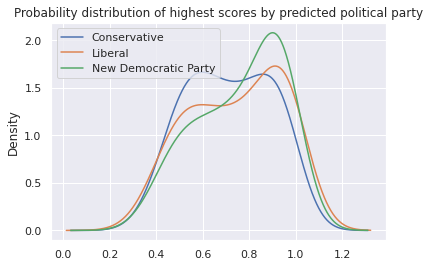

In [0]:
# plot density of scores by predicted political class
import matplotlib.pyplot as plt
res.groupby([res.pred_label]).highest_proba.plot.kde(bw_method=0.5);
plt.title("Probability distribution of highest scores by predicted political party")
plt.legend()

This density plot allows us to notice that speeches that are classified as NDP and Liberal speeches are assigned to those classes with higher probabilities compared to speeches that are assigned to the Conservative class: most of them are associated to this class with more spread probabilities.

In [0]:
# by pred_label find the row with the highest_proba
# res.groupby(['pred_label'])['highest_proba'].max()
res.groupby(['pred_label'])['highest_proba'].idxmax()

pred_label
Conservative            6939
Liberal                 5177
New Democratic Party    5924
Name: highest_proba, dtype: int64

In [0]:
# get indexes of rows with the highest probability py predicted class
top = res.groupby(['pred_label'])['highest_proba'].nlargest(3).index.values
top

array([('Conservative', 6939), ('Conservative', 4217),
       ('Conservative', 6991), ('Liberal', 5177), ('Liberal', 5615),
       ('Liberal', 7191), ('New Democratic Party', 5924),
       ('New Democratic Party', 1372), ('New Democratic Party', 4368)],
      dtype=object)

In [0]:
top_index = [lis[1] for lis in top]
top_index

[6939, 4217, 6991, 5177, 5615, 7191, 5924, 1372, 4368]

In [0]:
res2 = res.iloc[top_index]
res2

,index,predicted_class,true_class,highest_proba,pred_label,true_label
6939,6939,0,0,0.992307,Conservative,Conservative
4217,4217,0,0,0.989430,Conservative,Conservative
6991,6991,0,0,0.989003,Conservative,Conservative
5177,5177,1,1,0.995817,Liberal,Liberal
5615,5615,1,1,0.995439,Liberal,Liberal
7191,7191,1,1,0.995425,Liberal,Liberal
5924,5924,2,2,0.991417,New Democratic Party,New Democratic Party
1372,1372,2,2,0.990737,New Democratic Party,New Democratic Party
4368,4368,2,2,0.990376,New Democratic Party,New Democratic Party


In [0]:
# retrieve all original speeches from test data
allspeeches = []
for batch in test_iterator_lstm:
  text, text_lengths = batch.speechtext
  text.transpose_(0, 1)
  speechbatch = [[TEXT_lstm.vocab.itos[word] for word in ind] for ind in text] #if word !=1
  #print(speechbatch)
  #break
  allspeeches.extend(speechbatch)
len(allspeeches)==len_test_lstm   

True

In [0]:
speeches = [' '.join(allspeeches[i]) for i in top_index]

In [0]:
res2["speech"] = speeches

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
res2

,index,predicted_class,true_class,highest_proba,pred_label,true_label,speech
6939,6939,0,0,0.992307,Conservative,Conservative,Mr Chair we have spent a lot of time talking a...
4217,4217,0,0,0.989430,Conservative,Conservative,Mr Speaker yesterday in the worst April Fool s...
6991,6991,0,0,0.989003,Conservative,Conservative,Mr Speaker it is a pleasure to join the debate...
5177,5177,1,1,0.995817,Liberal,Liberal,Mr Speaker I move That in relation to its stud...
5615,5615,1,1,0.995439,Liberal,Liberal,Madam Speaker I did not quite expect an issue ...
7191,7191,1,1,0.995425,Liberal,Liberal,Madam Speaker I will be splitting my time with...
5924,5924,2,2,0.991417,New Democratic Party,New Democratic Party,Mr Speaker I thank my colleague from Skeena Bu...
1372,1372,2,2,0.990737,New Democratic Party,New Democratic Party,Mr Speaker I have a petition signed by literal...
4368,4368,2,2,0.990376,New Democratic Party,New Democratic Party,Mr Speaker I thank my colleague from Vancouver...


Let's have a look at the speeches that were assigned to a political class with the highest probability.

In [0]:
# Liberal top speech
speechLib = allspeeches[res2.index[0]]
speechLib = ' '.join(speechLib)
speechLib

'Mr Chair we have spent a lot of time talking about tax free savings accounts and it seems that we have not been able to penetrate the opposition members who are focused on a misunderstanding of the central fact that TFSAs overwhelmingly benefit low and middle income Canadians Two thirds of the benefits go to them and 25 to families earning less than 30 000 a year The TFSA is a marvellous tool to save for a first home for the kids education or for retirement Of the 11 million Canadians who participate three quarters of them earn less than 75 000 a year half of them earn less than 42 000 a year and 60 of those who have maxed out earn less than 60 000 a year This is a very important measure for low and middle income Canadians and of course for seniors This is part of our government s plan to create jobs growth and long term prosperity Since we have spent so much time discussing the TFSAs perhaps I could move on to the broader discussion of Canada s economy Through Canada s economic actio

In [0]:
# Conservative top speech
speechCons = allspeeches[res2.index[3]]
speechCons= ' '.join(speechCons)
speechCons

'Mr Speaker I move That in relation to its study of the pre budget consultations in advance of the 2018 budget seven members of the Standing Committee on Finance be authorized to travel to St John s Newfoundland and Labrador Halifax Nova Scotia Montreal Quebec and Windsor and Toronto Ontario in the Summer or Fall of 2017 and that the necessary staff accompany the Committee I move That in relation to its study of the pre budget consultations in advance of the 2018 budget seven members of the Standing Committee on Finance be authorized to travel to Vancouver British Columbia Yellowknife Northwest Territories Calgary Alberta and Saskatoon Saskatchewan in the Summer or Fall of 2017 and that the necessary staff accompany the Committee I move That in relation to its study of the pre budget consultations in advance of the 2018 budget seven members of the Standing Committee on Finance be authorized to travel to Washington D C and New York New York United States of America in the Summer or Fall

In [0]:
# NDP top speech
speechND = allspeeches[res2.index[6]]
speechND = ' '.join(speechND)
speechND

'Mr Speaker I thank my colleague from Skeena Bulkley Valley who raised some very important points What we are trying to do with respect to Bill C 51 is a matter of principle We are a party of principles and nothing could make us vote in favour of a bill that violates our rights and civil liberties as much as Bill C 51 does We are people of principle Early on the polls did not support our position not at all We stood up anyway Our leader a very principled man stood up and decided that no we would not support something that is an attack on the Canadian Charter of Rights and Freedoms and an attack on our fundamental rights Frankly this is partisan politics This is putting partisanship before principles which we will never accept We will not get involved in the Conservatives game or the Liberals when our rights and civil liberties are being attacked I am proud to stand up today with my caucus colleagues to once again support the amendments we are proposing The government needs to go back t

We also create a function that uses our LSTM model to predict a political class of any given speech.

In [0]:
import torch.nn.functional as F
import spacy
nlp = spacy.load('en')

def predict_party(model, speech):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(speech)]
    #tokenized = [token.lemma_.lower() for token in spacy_en.tokenizer(speech) if not token.is_stop | token.is_punct | token.is_space]  # maybe also remove figures
    #print(tokenized)
    indexed = [TEXT_lstm.vocab.stoi[t] for t in tokenized]
    print(indexed)
    length = [len(indexed)]
    #print(length)
    tensor = torch.LongTensor(indexed).to(device)
    #print(tensor)
    tensor = tensor.unsqueeze(1)
    #print(tensor)
    length_tensor = torch.LongTensor(length)
    #print(length_tensor)
    preds = model_lstm(tensor, length_tensor)
    #print(preds)
    preds = F.softmax(preds, dim = 1)
    print("Probability scores:", preds)
    max_preds = preds.argmax(dim = 1)
    print("Final predicted class:", max_preds.item())
    print(f'Predicted class is: {max_preds.item()} = {LABEL_lstm.vocab.itos[max_preds.item()]}')
    return()

In [0]:
predict_party(model_lstm, speechLib)

[38, 563, 14, 13, 674, 9, 250, 4, 61, 287, 36, 110, 329, 1232, 2246, 5, 15, 672, 6, 14, 13, 18, 54, 232, 3, 18378, 2, 265, 81, 42, 12, 1348, 17, 9, 8376, 4, 2, 2538, 147, 6, 4188, 5832, 249, 682, 5, 306, 303, 49, 2988, 4249, 4, 2, 371, 164, 3, 76, 5, 873, 3, 201, 2917, 459, 115, 551, 175, 9, 116, 23, 2806, 8, 9, 13640, 1896, 3, 1021, 11, 9, 114, 339, 11, 2, 1252, 611, 47, 11, 997, 1039, 2, 844, 192, 49, 42, 1070, 298, 6387, 4, 76, 2125, 459, 115, 1606, 175, 9, 116, 797, 4, 76, 2125, 459, 115, 3368, 175, 9, 116, 5, 1303, 4, 71, 42, 13, 11833, 89, 2125, 459, 115, 1303, 175, 9, 116, 69, 8, 9, 58, 84, 825, 11, 682, 5, 306, 303, 49, 5, 4, 404, 11, 452, 69, 8, 172, 4, 25, 21, 37, 194, 3, 347, 165, 451, 5, 237, 497, 1340, 986, 14, 13, 674, 68, 178, 61, 2272, 2, 4188, 869, 10, 109, 384, 17, 3, 2, 2410, 817, 4, 28, 37, 193, 1989, 28, 37, 230, 278, 194, 25, 96, 37, 193, 29, 359, 59, 4, 2, 295, 230, 9035, 636, 41, 1782, 297, 26, 14, 13, 106, 83, 386, 133, 28, 8, 18, 6489, 3, 686, 230, 807, 1098, 

()

In [0]:
predict_party(model_lstm, speechCons)

[38, 33, 10, 384, 66, 7, 1784, 3, 101, 607, 4, 2, 1428, 136, 953, 7, 1333, 4, 2, 966, 136, 1353, 81, 4, 2, 389, 547, 17, 763, 20, 3096, 3, 1085, 3, 1023, 1318, 37, 1462, 5, 1768, 2921, 1786, 2058, 1319, 405, 5, 2527, 5, 712, 445, 7, 2, 7878, 47, 9154, 4, 695, 5, 6, 2, 572, 810, 5450, 2, 547, 10, 384, 66, 7, 1784, 3, 101, 607, 4, 2, 1428, 136, 953, 7, 1333, 4, 2, 966, 136, 1353, 81, 4, 2, 389, 547, 17, 763, 20, 3096, 3, 1085, 3, 909, 571, 692, 8488, 2082, 2127, 1468, 543, 5, 3233, 1240, 7, 2, 7878, 47, 9154, 4, 695, 5, 6, 2, 572, 810, 5450, 2, 547, 10, 384, 66, 7, 1784, 3, 101, 607, 4, 2, 1428, 136, 953, 7, 1333, 4, 2, 966, 136, 1353, 81, 4, 2, 389, 547, 17, 763, 20, 3096, 3, 1085, 3, 3383, 3268, 97, 5, 368, 1983, 368, 1983, 357, 515, 4, 2012, 7, 2, 7878, 47, 9154, 4, 695, 5, 6, 2, 572, 810, 5450, 2, 547, 0, 15463, 0]
Probability scores: tensor([[0.0040, 0.9911, 0.0049]], device='cuda:0', grad_fn=<SoftmaxBackward>)
Final predicted class: 1
Predicted class is: 1 = Liberal


()

In [0]:
predict_party(model_lstm, speechND)

[38, 33, 10, 156, 35, 93, 31, 4396, 4445, 1919, 42, 546, 86, 58, 84, 958, 204, 14, 12, 403, 3, 44, 19, 211, 3, 100, 97, 1362, 8, 9, 407, 4, 1027, 34, 12, 9, 323, 4, 1312, 5, 395, 109, 98, 77, 343, 7, 1036, 4, 9, 55, 6, 7463, 25, 200, 5, 1453, 3744, 26, 178, 26, 100, 97, 1362, 117, 34, 12, 50, 4, 1027, 10146, 17, 2, 4579, 121, 18, 102, 25, 516, 18, 46, 41, 34, 1657, 91, 4423, 300, 391, 9, 58, 6047, 1363, 1657, 91, 5, 1025, 6, 104, 14, 22, 18, 102, 225, 6, 8, 43, 1433, 17, 2, 65, 2111, 4, 895, 5, 2343, 5, 43, 1433, 17, 25, 972, 200, 4609, 16, 8, 1249, 1251, 69, 8, 696, 4064, 168, 1312, 53, 14, 24, 376, 1517, 34, 24, 18, 118, 663, 7, 2, 155, 1994, 47, 2, 131, 64, 25, 200, 5, 1453, 3744, 12, 119, 4133, 10, 72, 310, 3, 369, 91, 105, 19, 35, 1326, 331, 3, 536, 261, 102, 2, 318, 14, 12, 1562, 23, 21, 286, 3, 164, 162, 3, 2, 4810, 1282, 5, 206, 91, 19, 9, 1199, 6, 1149, 11, 41, 49, 967, 4, 2030, 9, 8646, 55, 67, 100, 97, 1362, 0, 15463, 0, 0, 15463, 0]
Probability scores: tensor([[0.0046, 0.00

()

In order to later compare the way bi-LSTM and HAN classify speeches of the test set, we extract the index of correctly classified speeches by real political party.

In [0]:
acc_speech_LSTM = res[res['pred_label'] == res['true_label']].index.tolist()

In [0]:
# let's check we recover the model accuracy
len(acc_speech_LSTM)/len_test_lstm == accuracy_lstm

True

>

### **HAN model**

**Data preparation**

We here proceed the same way we did for the Bi-LSTM model. However, the pre-processing steps are here not the same.


In [0]:
# First define the way we want to tokenize data :

def tokenizer_sent(input):
  return [str(sent) for sent in spacy_en(input).sents]

def tokenizer_word_regex(x):
  tok = nltk.RegexpTokenizer(r'\w+')
  return([i for i in tok.tokenize(x)])

# Then define a function to pre-process data 
def preprocess_han_torchtext(pretrained_emb_name, batch_size, min_freq = 1, verbose = True, full=True) :

  """ 
    INPUTS : 
    - pre-trained embeddings name
    - batch_size
    - min_freq : minimum frequence required for building vocabulary. Default = 1
    - full = True to work with full speeches, set it to False otherwise 

    OUTPUT : train iterator, test iterator, validation iterator, TEXT, LABEL and length of the test_data

    In this preprocessing we : 
    - build the vocab from pretrained embeddings
    - create bucket iterators

  """ 
  
  NESTED = data.Field(tokenize=tokenizer_word_regex)
  TEXT = data.NestedField(NESTED, tokenize=tokenizer_sent)
  LABEL = data.LabelField()

  
  # evaluation and validation is done on full speeches, only the training set should be different
  df_datafields = [("speechtext", TEXT), ("speechtextFiltered_un", None), ("speakerparty", LABEL)]
  
  test_data = data.TabularDataset(path = "test2.csv",
                                  format = "CSV",
                                  fields = df_datafields,
                                  skip_header=True)

  val_data = data.TabularDataset(path = "validation.csv",
                                 format = "CSV",
                                 fields = df_datafields,
                                 skip_header=True)


  # data selection : when declaring datafields, only the order matters, not the name of the fields
  if full is True :
    # the 1st column of the data of interest is declared as TEXT and the 3rd comumn as LABEL, the 2nd is ignored
    df_datafields = [("speechtext", TEXT), ("speechtextFiltered_un", None), ("speakerparty", LABEL)]
    train_data = data.TabularDataset(path = "train.csv",
                                     format = "CSV",
                                     fields = df_datafields,
                                     skip_header=True)
  else :
    # the 2nd column of the data of interest is declared as TEXT and the 3rd comumn as LABEL, the 1st is ignored
    df_datafields = [("speechtext", None), ("speechtext", TEXT), ("speakerparty", LABEL)]
    train_data = data.TabularDataset(path = "train.csv",
                                     format = "CSV",
                                     fields = df_datafields,
                                     skip_header=True)


  # Build vocabulary
  TEXT.build_vocab(train_data, 
                   vectors = pretrained_emb_name,
                   unk_init = torch.Tensor.normal_, 
                   min_freq = min_freq)
  LABEL.build_vocab(train_data)


  # We can now create the iterators through which we will go when training and evaluating the model.
  # As we are dealing with documents of varying lengths, we use the bucketing technique in order to make sure that each 
  # batch is composed of speeches which have a same order of length. 
  # This will prevent from padding too much the shortest sentences and from wasting computation power. 

  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, val_data, test_data), 
      batch_size = batch_size,
      sort_key = lambda x: len(x.speechtext),
      sort_within_batch = True,
      device = device)

  if verbose:
    print("Length train data : {} \nLength test data : {} \nLength validation data : {}".format(len(train_data), len(test_data), len(val_data)))
    print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
    print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}") 
    print("The mapping of the labels is  ", LABEL.vocab.stoi)
    print("Most common words:", TEXT.vocab.freqs.most_common(15))
    print("Training data example:", vars(train_data[0]))

  
  return(train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len(test_data))

**Let's now implement all the functions we need for our HANmodel.**

Let's begin by creating the HAN class.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):

  def __init__(self, input_dim, hidden_dim):
    super(Attention, self).__init__()

    self.linear_in = nn.Linear(in_features = input_dim, out_features = hidden_dim)
    self.context = nn.Linear(in_features = hidden_dim, out_features = 1, bias = False)

  def forward(self, input):
    # input has size [batch, seq_len, dimension]
    #print("input for attention has size [batch, seq_len, dimension]", input.shape)
    input = self.linear_in(input)
    #print("input for attention after 1 linear transformation", input.shape)
    input = torch.tanh(input)  # (n_words, att_size)
    scores = self.context(input)
    #print("word-level context vectos dimension [batch, seq_len, 1]", scores.shape)
    # unnormalized score, dimensions [batch, seq_len, 1]
    scores = F.softmax(scores, dim = 1) # normalize across sequence dimension
    #print("weights after softmax", scores.shape)
    input = input * scores
    #print("output from attention shape before sum", input.shape)
    #print("output from attention shape", input.sum(dim=1).shape)
    return(input.sum(dim = 1), scores)

class HAN(nn.Module):
  def __init__(self, vocab_size, emb_dim, word_dim, word_attn_dim, sent_dim, sent_attn_dim, dropout, pad_idx):
    super(HAN, self).__init__()

    self.embed_dim = emb_dim
    self.embeds = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
    self.word_rnn = nn.GRU(input_size=emb_dim, hidden_size=word_dim, batch_first=True, bidirectional=True, dropout=dropout)
    self.word_attn = Attention(2*word_dim, word_attn_dim)
    self.sent_rnn = nn.GRU(input_size=2*word_dim, hidden_size=sent_dim, batch_first=True, bidirectional=True, dropout=dropout) # avant, input_size = 2*word_dim
    self.sent_attn = Attention(2*sent_dim, sent_attn_dim)
    self.classifier = nn.Linear(in_features=2*sent_dim, out_features=3)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input):
    # input will have dimension [batch_size, num_sents, num_words]
    #print("input shape : input will have dimension [batch_size, num_sents, num_words]", input.shape)
    #print(input)
    batch_size, num_sents, num_words = input.shape
    
    input = self.dropout(self.embeds(input))
    #print("embeds.shape [batch_size, num_sents, num_words, emb_dim]", input.shape)
        
    # shape: [batch_size, num_sents, num_words, emb_dim]
    input = input.view(-1, num_words, self.embed_dim)
    #print("embeds shape after reshaping", input.shape)
    word_out, _ = self.word_rnn(input)
    #print("word_out1 shape: [batch_size x num_sents, num_words, 2*word_out]", word_out.shape)

    # shape: [batch_size x num_sents, num_words, 2*word_out]
    word_out, word_atn_weights = self.word_attn(word_out)
    #print("word out 2 shape: [batch_size x num_sents, 2*word_out]", word_out.shape )
        
    # shape: [batch_size x num_sents, 2*word_out]
    word_out = word_out.view(batch_size, num_sents, -1)
    #print("word_out 3 shape: [batch_size, num_sents, word_out]", word_out.shape)
    # shape: [batch_size, num_sents, word_out]
    word_atn_weights = word_atn_weights.view(batch_size, num_sents, -1)
    #print("word attention shape after reshaping ", word_atn_weights.shape)
        
    sent_out, _ = self.sent_rnn(word_out)   
    sent_out, sent_atn_weights = self.sent_attn(sent_out)
        
    # shape: [batch_size, 2*sent_out]
    return self.classifier(sent_out), word_atn_weights, sent_atn_weights


**Training function**

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
       
        optimizer.zero_grad()    
        
        predictions, _, _ = model(batch.speechtext)
        predictions = predictions.squeeze(1)
        
        loss = criterion(predictions, batch.speakerparty)
        
        acc = categorical_accuracy(predictions, batch.speakerparty)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return(epoch_loss / len(iterator), epoch_acc / len(iterator))

**Evaluation Loop**

In [0]:
def evaluate(model, iterator, criterion, return_pred=False):
    
    epoch_loss = 0
    epoch_acc = 0
    tot_ytrue = []
    tot_ypred = []
    probs = []
    tot_word_weight = []
    tot_sentence_weight = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions, word_weight, sentence_weight = model(batch.speechtext)
            predictions = predictions.squeeze(1)

            preds = predictions.argmax(dim=1, keepdim=True)
            #print("Predictions", preds)
            #print("word weight shape1", word_weight.shape)
            
            predictions_tolist = preds.cpu().tolist()
            tot_ypred.append(predictions_tolist)
            #print(predictions)
            prob = F.softmax(predictions, dim = 1)
            #print(prob)
            probs.append(prob.cpu().tolist())

            # Word weight
            #word_weight = word_weight.squeeze(2)
            #batch_size, num_sents, num_words = word_weight.shape
            #print("word weight shape2", word_weight.view(batch_size, num_sents* num_words).shape)
            word_weight = word_weight.cpu().tolist()
            tot_word_weight.extend(word_weight)

            # sentence weight
            sentence_weight = sentence_weight.squeeze(-1)
            #print("sentence weight squeeze shape", sentence_weight.shape)
            sentence_weight = sentence_weight.cpu().tolist()
            tot_sentence_weight.extend(sentence_weight)


            y_true_np = batch.speakerparty.cpu().tolist()
            tot_ytrue.append(y_true_np)
            
            loss = criterion(predictions, batch.speakerparty)
            
            acc = categorical_accuracy(predictions, batch.speakerparty)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
         
    if return_pred==True:
      return(epoch_loss / len(iterator), epoch_acc / len(iterator), tot_ytrue, tot_ypred, probs,tot_word_weight, tot_sentence_weight)
    else:
      return(epoch_loss / len(iterator), epoch_acc / len(iterator))

**Model parameters** that do not depend on the datset we choose.

In [0]:
EMBEDDING_DIM = 100
WORD_DIM = 32
WORD_ATTN_DIM = 64
SENT_DIM = 32
SENT_ATTN_DIM = 64
DROPOUT = 0.2

**We can now create a function that trains the HAN model depending on the chosen datset.** 
As before : 
* We chose to keep the Adam optimizer as it allows to take into account different learning rates for the different model parameters.
* For our multi-class classification task , we use the Cross Entropy Loss.

We need to before stock objects for filtered and non-filtered speeches, that we be passed as the arguments on the training function.

In [22]:
train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len_test = preprocess_han_torchtext(pretrained_emb_name="glove.6B.100d", batch_size = 32, min_freq = 1, verbose = True, full = True)

Length train data : 60675 
Length test data : 7584 
Length validation data : 7585
Unique tokens in TEXT vocabulary: 66328
Unique tokens in LABEL vocabulary: 3
The mapping of the labels is   defaultdict(<function _default_unk_index at 0x7fecf0064ae8>, {'Conservative': 0, 'Liberal': 1, 'New Democratic Party': 2})
Most common words: [('the', 853835), ('to', 532130), ('of', 411224), ('and', 382868), ('that', 302965), ('in', 274834), ('is', 260898), ('a', 251487), ('I', 184261), ('for', 153762), ('are', 128958), ('have', 124701), ('we', 123273), ('it', 116315), ('this', 111308)]
Training data example: {'speechtext': [['Mr', 'Speaker', 'I', 'thank', 'my', 'colleague', 'for', 'his', 'question'], ['I', 'do', 'not', 'want', 'to', 'mix', 'up', 'the', 'two', 'files'], ['There', 'is', 'the', 'issue', 'of', 'people', 'arriving', 'from', 'the', 'United', 'States'], ['However', 'today', 'we', 'are', 'debating', 'Bill', 'C', '23', 'which', 'seeks', 'to', 'make', 'improvements', 'and', 'to', 'increase'

In [63]:
train_iterator_filt, test_iterator_filt, valid_iterator_filt, TEXT_filt, LABEL_filt, len_test_filt = preprocess_han_torchtext(pretrained_emb_name="glove.6B.100d", batch_size = 32, min_freq = 1, verbose = True, full = False)

Length train data : 60675 
Length test data : 7584 
Length validation data : 7585
Unique tokens in TEXT vocabulary: 50282
Unique tokens in LABEL vocabulary: 3
The mapping of the labels is   defaultdict(<function _default_unk_index at 0x7fecf0064ae8>, {'Conservative': 0, 'Liberal': 1, 'New Democratic Party': 2})
Most common words: [('the', 380149), ('to', 233644), ('of', 182172), ('and', 168361), ('that', 135249), ('in', 118564), ('is', 112038), ('a', 106941), ('I', 83897), ('for', 68229), ('are', 55625), ('we', 53811), ('have', 53646), ('it', 50554), ('on', 50024)]
Training data example: {'speechtext': [['Mr', 'Speaker', 'I', 'thank', 'my', 'colleague', 'for', 'his', 'question'], ['I', 'do', 'not', 'want', 'to', 'mix', 'up', 'the', 'two', 'files'], ['There', 'is', 'the', 'issue', 'of', 'people', 'arriving', 'from', 'the', 'United', 'States'], ['However', 'today', 'we', 'are', 'debating', 'Bill', 'C', '23', 'which', 'seeks', 'to', 'make', 'improvements', 'and', 'to', 'increase', 'the', 

Let's define our function

In [0]:
def training_han_model(train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len_test, N_EPOCHS = 5, lr = 0.005, full = True):

  # Model parameters depending on the data
  INPUT_DIM = len(TEXT.vocab)
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

  # Model
  model = HAN(INPUT_DIM, 
              EMBEDDING_DIM, 
              WORD_DIM, 
              WORD_ATTN_DIM, 
              SENT_DIM, 
              SENT_ATTN_DIM, 
              DROPOUT, 
              PAD_IDX)
  
  # Initialization of the weight matrix with pretrained embeddings
  model.embeds = model.embeds.from_pretrained(TEXT.vocab.vectors)

  # Optimizer and loss function 
  optimizer = optim.Adam(model.parameters(), lr = lr)
  criterion = nn.CrossEntropyLoss()

  model = model.to(device)
  criterion = criterion.to(device)

  #training loop 

  best_valid_loss = float('inf')

  for epoch in range(N_EPOCHS):

      start_time = time.time()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      valid_loss, valid_acc, y_true, y_pred, probs, word_weight, sentence_weight = evaluate(model, valid_iterator, criterion, return_pred=True)
      
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          if full is True : 
            torch.save(model.state_dict(), 'han_model_full2.pt')
          else :
            torch.save(model.state_dict(), 'han_model_filtered2.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  
  return(model, test_iterator, criterion, TEXT, LABEL, len_test)


**Let's train the model on both filtered and non-filtered speeches.**

Training on filtered speeches.

In [66]:
# training of the model on filtered speeches
start_time = time.time()
model_han_fil, test_iterator_han_fil, criterion_han_fil, TEXT_han_fil, LABEL_han_fil, len_test_han_fil = training_han_model(train_iterator_filt, test_iterator_filt, valid_iterator_filt, TEXT_filt, LABEL_filt, len_test_filt,N_EPOCHS = 5, lr = 0.005, full = False)
print("Time elapsed : %s seconds" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 1.022 | Train Acc: 46.02%
	 Val. Loss: 0.936 |  Val. Acc: 53.64%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.955 | Train Acc: 52.98%
	 Val. Loss: 0.904 |  Val. Acc: 56.50%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.926 | Train Acc: 55.26%
	 Val. Loss: 0.875 |  Val. Acc: 58.51%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.911 | Train Acc: 55.89%
	 Val. Loss: 0.903 |  Val. Acc: 54.98%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.902 | Train Acc: 56.74%
	 Val. Loss: 0.860 |  Val. Acc: 59.01%
Time elapsed : 168.71579933166504 seconds


*Results we got from the last running of our code and that is commented in the report.*

```
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 1.022 | Train Acc: 46.02%
	 Val. Loss: 0.936 |  Val. Acc: 53.64%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.955 | Train Acc: 52.98%
	 Val. Loss: 0.904 |  Val. Acc: 56.50%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.926 | Train Acc: 55.26%
	 Val. Loss: 0.875 |  Val. Acc: 58.51%
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 0.911 | Train Acc: 55.89%
	 Val. Loss: 0.903 |  Val. Acc: 54.98%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.902 | Train Acc: 56.74%
	 Val. Loss: 0.860 |  Val. Acc: 59.01%
```



Training on the full speeches.

In [28]:
# training of the model on full speeches
start_time = time.time()
model_han, test_iterator_han, criterion_han, TEXT_han, LABEL_han, len_test_han = training_han_model(train_iterator, test_iterator, valid_iterator, TEXT, LABEL, len_test, N_EPOCHS = 5, lr = 0.005, full = True)
print("Time elapsed : %s seconds" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.000 | Train Acc: 47.82%
	 Val. Loss: 0.941 |  Val. Acc: 53.07%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 0.895 | Train Acc: 56.92%
	 Val. Loss: 0.864 |  Val. Acc: 58.80%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 0.861 | Train Acc: 59.17%
	 Val. Loss: 0.866 |  Val. Acc: 58.69%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.842 | Train Acc: 60.36%
	 Val. Loss: 0.889 |  Val. Acc: 58.36%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.828 | Train Acc: 61.07%
	 Val. Loss: 0.809 |  Val. Acc: 62.08%
Time elapsed : 236.21712231636047 seconds


*Results we got from the last running of our code and that is commented in the report.*

```
Epoch: 01 | Epoch Time: 0m 46s
	Train Loss: 1.000 | Train Acc: 47.82%
	 Val. Loss: 0.941 |  Val. Acc: 53.07%
Epoch: 02 | Epoch Time: 0m 47s
	Train Loss: 0.895 | Train Acc: 56.92%
	 Val. Loss: 0.864 |  Val. Acc: 58.80%
Epoch: 03 | Epoch Time: 0m 46s
	Train Loss: 0.861 | Train Acc: 59.17%
	 Val. Loss: 0.866 |  Val. Acc: 58.69%
Epoch: 04 | Epoch Time: 0m 48s
	Train Loss: 0.842 | Train Acc: 60.36%
	 Val. Loss: 0.889 |  Val. Acc: 58.36%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.828 | Train Acc: 61.07%
	 Val. Loss: 0.809 |  Val. Acc: 62.08%
```



#### **Quantitative evaluation on the test set**

Let's load the model built on the filtered speeches.

In [67]:
model_han_fil.load_state_dict(torch.load('han_model_filtered2.pt'))

test_loss_han_fil, test_acc_han_fil, tot_ytrue_han_fil, tot_ypred_han_fil, probs_han_fil, word_weight_han_fil, sentence_weight_han_fil = evaluate(model_han_fil, test_iterator_han_fil, criterion_han_fil, return_pred=True)

print(f'Test Loss: {test_loss_han_fil:.3f} | Test Acc: {test_acc_han_fil*100:.2f}%')

Test Loss: 0.855 | Test Acc: 59.06%


In [0]:
# get the results in a list object
y_test_han_fil = [item for sublist in tot_ytrue_han_fil for item in sublist]
y_pred_han_fil = [item for sublist in tot_ypred_han_fil for item in sublist]
probs_han_fil = [item for sublist in probs_han_fil for item in sublist]

In [70]:
# Confusion matrix and F1 metrics

cm_han_fil = confusion_matrix(y_test_han_fil, y_pred_han_fil)
cr_han_fil = classification_report(y_test_han_fil, y_pred_han_fil)
accuracy_han_fil = accuracy_score(y_test_han_fil, y_pred_han_fil)
f1_han_fil = f1_score(y_test_han, y_pred_han_fil, average='weighted')

print("Confusion Matrix:\n",cm_han_fil)
print("Classification Report:\n", cr_han_fil)
print("Accuracy : ", accuracy_han_fil)
print("F1 score : ", f1_han_fil)

Confusion Matrix:
 [[1622  513  735]
 [ 692 1304  613]
 [ 379  173 1553]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58      2870
           1       0.66      0.50      0.57      2609
           2       0.54      0.74      0.62      2105

    accuracy                           0.59      7584
   macro avg       0.60      0.60      0.59      7584
weighted avg       0.60      0.59      0.59      7584

Accuracy :  0.5905854430379747
F1 score :  0.587971742247523


Let's load the model built with full speeches.

In [30]:
model_han.load_state_dict(torch.load('han_model_full2.pt'))

test_loss_han, test_acc_han, tot_ytrue_han, tot_ypred_han, probs_han, word_weight_han, sentence_weight_han = evaluate(model_han, test_iterator_han, criterion_han, return_pred=True)

print(f'Test Loss: {test_loss_han:.3f} | Test Acc: {test_acc_han*100:.2f}%')

Test Loss: 0.803 | Test Acc: 62.63%


We notice the slightly poorer performance of HAN when used on filtered speeches. Consequently, we herebelow, analyse more deeply the results from the model trained on full speeches.

In [0]:
# get the results in a list object
y_test_han = [item for sublist in tot_ytrue_han for item in sublist]
y_pred_han = [item for sublist in tot_ypred_han for item in sublist]
probs_han = [item for sublist in probs_han for item in sublist]

In [33]:
# Confusion matrix and F1 metrics

cm_han = confusion_matrix(y_test_han, y_pred_han)
cr_han = classification_report(y_test_han, y_pred_han)
accuracy_han = accuracy_score(y_test_han, y_pred_han)
f1_han = f1_score(y_test_han, y_pred_han, average='weighted')

print("Confusion Matrix:\n",cm_han)
print("Classification Report:\n", cr_han)
print("Accuracy : ", accuracy_han)
print("F1 score : ", f1_han)

Confusion Matrix:
 [[1777  796  297]
 [ 604 1803  202]
 [ 479  456 1170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62      2870
           1       0.59      0.69      0.64      2609
           2       0.70      0.56      0.62      2105

    accuracy                           0.63      7584
   macro avg       0.64      0.62      0.63      7584
weighted avg       0.63      0.63      0.63      7584

Accuracy :  0.6263185654008439
F1 score :  0.6258299889674124


>

#### **Qualitative evaluation on the test set**

In the HAN model, the word attention weights and the sentence attention weights reflect the importance of the words and the sentences in a speech. Consequently, the HAN model should have given high weights to the most significant words and sentences, i.e. words and sentences with a discriminative power for the classification should have higher weights. 

We wish to visualize those weights on some selected speeches. 

Let's first construct a dataset to summarize the results of our predictions on the test data.

In [34]:
import operator
from functools import reduce #python 3

# extract the maximum probability to be assigned to a class for each document
prob_max_han = [max(p) for p in probs_han] 

# convert y_pred object to a list object
pred_class_han =  reduce(operator.concat, y_pred_han)

# rename true class vector
y_true_han = y_test_han

# index list with length equal to the number of speeches in the test set
idx = range(len(word_weight_han))
#idx = range(len(test_data))

# summarize the information in a dataframe
res =  pd.DataFrame({'index': idx , 'predicted_class': pred_class_han, 'true_class': y_true_han, 'highest_proba': prob_max_han})
res['pred_label'] = res.predicted_class.apply(lambda x : LABEL_han.vocab.itos[x])
res['true_label'] = res.true_class.apply(lambda x : LABEL_han.vocab.itos[x])
res['right_pred'] = res.predicted_class == res.true_class # true if prediction is right

# Distribution du nombre de phrases
sent_weight_len_han = [len(x) for x in sentence_weight_han]
res["sent_len"] = sent_weight_len_han

#res.sort_values(by=['highest_proba'], ascending=False, inplace=True)
res.head(10)

,index,predicted_class,true_class,highest_proba,pred_label,true_label,right_pred,sent_len
0,0,2,0,0.494858,New Democratic Party,Conservative,False,1
1,1,0,1,0.713409,Conservative,Liberal,False,1
2,2,0,1,0.593566,Conservative,Liberal,False,1
3,3,0,0,0.489330,Conservative,Conservative,True,1
4,4,0,0,0.764027,Conservative,Conservative,True,1
5,5,0,2,0.915136,Conservative,New Democratic Party,False,1
6,6,0,1,0.467080,Conservative,Liberal,False,1
7,7,0,0,0.479905,Conservative,Conservative,True,1
8,8,0,2,0.667510,Conservative,New Democratic Party,False,1
9,9,0,2,0.643741,Conservative,New Democratic Party,False,1


Let's look at the distribution of scores for each predicted class.



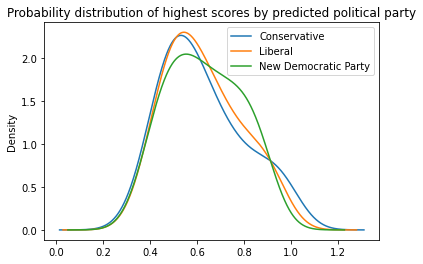

In [35]:
# plot density of scores by predicted political class
import matplotlib.pyplot as plt
res.groupby([res.pred_label]).highest_proba.plot.kde(bw_method=0.5);
plt.title("Probability distribution of highest scores by predicted political party")
plt.legend()


**Keeping the speeches with the highest score for each party**

For each party, we keep the 3 speeches with the highest score. 

In [36]:
# get indexes of rows with the highest probability by predicted class
top_right = res[res.right_pred==True].groupby(['pred_label'])['highest_proba'].nlargest(3).index.values
top_right

top_right_index = [lis[1] for lis in top_right]
#print(top_right_index)
res_right = res.iloc[top_right_index]
res_right

,index,predicted_class,true_class,highest_proba,pred_label,true_label,right_pred,sent_len
5247,5247,0,0,0.985380,Conservative,Conservative,True,10
3801,3801,0,0,0.984565,Conservative,Conservative,True,8
4573,4573,0,0,0.982325,Conservative,Conservative,True,9
6832,6832,1,1,0.965381,Liberal,Liberal,True,22
7304,7304,1,1,0.963627,Liberal,Liberal,True,64
7368,7368,1,1,0.963166,Liberal,Liberal,True,68
5415,5415,2,2,0.932091,New Democratic Party,New Democratic Party,True,10
2526,2526,2,2,0.925454,New Democratic Party,New Democratic Party,True,6
1647,1647,2,2,0.922190,New Democratic Party,New Democratic Party,True,5


**We also take a look at the speeches that were misclassified with a high probability**

In [37]:
# get indexes of rows with the highest probability by predicted class that were misclassified
top_wrong = res[res.right_pred==False].groupby(['pred_label'])['highest_proba'].nlargest(3).index.values
top_wrong

top_wrong_index = [lis[1] for lis in top_wrong]
res_wrong = res.iloc[top_wrong_index]
res_wrong

,index,predicted_class,true_class,highest_proba,pred_label,true_label,right_pred,sent_len
3671,3671,0,2,0.973948,Conservative,New Democratic Party,False,8
1579,1579,0,2,0.969073,Conservative,New Democratic Party,False,5
6091,6091,0,2,0.956683,Conservative,New Democratic Party,False,12
6281,6281,1,0,0.944867,Liberal,Conservative,False,13
3765,3765,1,0,0.931697,Liberal,Conservative,False,8
1522,1522,1,2,0.912416,Liberal,New Democratic Party,False,5
7019,7019,2,1,0.922242,New Democratic Party,Liberal,False,45
7049,7049,2,1,0.900619,New Democratic Party,Liberal,False,48
7524,7524,2,0,0.876541,New Democratic Party,Conservative,False,84


We wish also to retrieve all the original speeches from the test_iterator object. They are currently in an index format (each words is an index in a dictionary of index). We convert an index to a word

In [38]:
# retrieve all original speeches from test data
allspeeches_han = []
for batch in test_iterator:
  batch_size, num_sents, num_words = batch.speechtext.shape
  x = batch.speechtext
  #Convert index to word
  speechbatch = [[[TEXT_han.vocab.itos[word] for word in ind ]for ind in ex ] for ex in x] #if word !=1
  #print(speechbatch)
  allspeeches_han.extend(speechbatch)

#check that it works
len(allspeeches_han)==len_test_han    

True

In [0]:
speeches =  [reduce(operator.concat, i) for i in allspeeches_han]
speeches = [' '.join(speeches[i]) for i in top_right_index]

In [40]:
res_right["speech"] = speeches
res_right

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,index,predicted_class,true_class,highest_proba,pred_label,true_label,right_pred,sent_len,speech
5247,5247,0,0,0.985380,Conservative,Conservative,True,10,Mr Speaker the tax free savings account is ano...
3801,3801,0,0,0.984565,Conservative,Conservative,True,8,Mr Speaker in the dark and dangerous world we ...
4573,4573,0,0,0.982325,Conservative,Conservative,True,9,Mr Speaker while Canada s economy is better th...
6832,6832,1,1,0.965381,Liberal,Liberal,True,22,The members laugh Mr Speaker <pad> <pad> <pad>...
7304,7304,1,1,0.963627,Liberal,Liberal,True,64,Mr Speaker I was a little disappointed with th...
7368,7368,1,1,0.963166,Liberal,Liberal,True,68,Mr Speaker I will be splitting my time with th...
5415,5415,2,2,0.932091,New Democratic Party,New Democratic Party,True,10,Mr Speaker interestingly in 2015 the Prime Min...
2526,2526,2,2,0.925454,New Democratic Party,New Democratic Party,True,6,Mr Speaker I thank my colleague for his speech...
1647,1647,2,2,0.922190,New Democratic Party,New Democratic Party,True,5,Mr Speaker I thank my colleague for her eloque...


**Deeper Qualitative Analysis**

We study here the weights that the HAN model assigned to words and sentences. The weights come from the attention mechanism and underline the impact of a word (within a sentence) and a sentence (within a speech) on the classification task. 

The following function allows to visualize the weights of each word in a sentence and of each sentence in a speech. 

In [0]:
def visualize_attention(index, export_word_name, export_sent_name, cmap="YlOrRd", verbose = True, veryverbose = False):
  """ 
  Function to visualize word and sentence weights in some examples

  INPUTS: 
  - index : index of the selected words in test_loader. They are in the dataframe res
  - export_word_name : name under which exporting the html file for word attention weights
  _ export_sent_name : name under which exporting the html file for sentence attention weights
  - cmap (Default : "Greens"). Color of the map. See https://matplotlib.org/tutorials/colors/colormaps.html for other examples
  - verbose : if some information about the undelying process is needed
  - veryverbose : for code debugging uniquely

  OUTPUT : 
  - visualization of word and sentence attention(html format)

  REQUIREMENTS : 
  - Having a list allspeeches in which all the speeches are appended
  - Having a list word_weight with all the word weights
  - Having a list sentence_weight with all the sentence weights


  Problem : the pads have positive weights that sum to a substantial amount
  This function first gets the total word weight without the pads 
  Then it visualizes the words with the new weights
  Then it gets the total sentence weight without the pads
  Then it visualizes the sentences with the new sentence weights
  """
  
  # speech, vector of word weights and vector of sentence weights
  speech = allspeeches_han[index]
  word_weight_ex = word_weight_han[index]
  sent_weight_ex = sentence_weight_han[index]
  
  # initializing visualization
  import matplotlib
  cmap = matplotlib.cm.get_cmap(cmap)
  template = '<font face="monospace" \nsize="3"; span class="barcode"; style="color: black; background-color: {}">{}</span>'
  template_sent = '<font face="monospace" \nsize="4"; span class="barcode"; style="color: black; background-color : background-color: grey;">{}</span>'
  colored_doc_sent = ""
  colored_doc_word = ""

  # 1. getting word attention
  for sent, word_w, sent_w in zip(speech, word_weight_ex, sent_weight_ex):
    if verbose:
      print("Sentence", sent)
      print("Weight of the sentence", word_w)

    sent_len, pad_count, tot_w_weight = len(sent), 0, 0
    #recuperating the total weight of the words without the pad (< 1)
    for t, w in zip(sent, word_w):
      if veryverbose : print("t", t, "w", w) 
      if t == '<pad>':
        pad_count+=1
        continue
      tot_w_weight+=w # adding the weights only if it is a real word and not a pad
    if verbose : print("Total word weight after rescaling", tot_w_weight)

    #Scaling the words with their new weights
    for t, w in zip(sent, word_w):
      if t == '<pad>':
        pad_count+=1
        continue
      w_scaled = w/tot_w_weight
      color_word = matplotlib.colors.rgb2hex(cmap(w_scaled)[:3])
      colored_doc_word += template.format(color_word, "&nbsp" + t + "&nbsp")
      
    colored_doc_word += "</br>" #new line at the end of a sentence
    

  # 2. Getting sentence weight
  tot_s_weight = 0
  for sent, sent_w in zip(speech, sent_weight_ex):
  #print(sent)
    #recuperating the total weight of the sentences without the pad (<=1)
    if verbose : print("sentence weight", sent_w)
    sent = ' '.join([t for t in sent if t!='<pad>']) 
    
    if len(sent) > 0:
      tot_s_weight += sent_w
  if verbose : print("Total sentence weight after rescaling", tot_s_weight)

  #Scaling the sentences with their new weights
  for sent, sent_w in zip(speech, sent_weight_ex):
    sent = ' '.join([t for t in sent if t!='<pad>']) 
    if len(sent)>0:
      s_scaled = sent_w/tot_s_weight
      
      color_sent = matplotlib.colors.rgb2hex(cmap(s_scaled)[:3])
      colored_doc_sent += template_sent.format(round(s_scaled, 2))
      colored_doc_sent += template.format(color_sent, "&nbsp" + sent + "&nbsp") +"</br>"

  # Visualizing word attention
  from IPython.display import display, HTML
  with open(export_word_name, 'w') as f:
    f.write(colored_doc_word)
  print("Word attention")
  display(HTML(export_word_name))

  # Visualizing sentence attention
  with open(export_sent_name, 'w') as f:
    f.write(colored_doc_sent)
  print("\nSentence attention")
  display(HTML(export_sent_name))
  



###**Let's visualize our predictions !**


####***Speeches classified as Conservative***

We visualize 3  predictions "Conservative"

In [42]:
# Conservative government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[0].true_label, res_right.iloc[0].pred_label))
print("Score : {}".format(res_right.iloc[0].highest_proba))
visualize_attention(res_right.iloc[0]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Conservative, 
Predicted label : Conservative
Score : 0.9853803515434265
Word attention



Sentence attention


In this example, important words are "recovery", "carbon", "job killing", "conservative", "government"

The sentence with the highest weight is "We will never punish Canadians with a job killing carbon tax", which has high emotional content. However, the sentences do not have very different weights. 

The HAN model has identified the main topic of the conversation (carbon tax) as well as the opinion of the speaker (job killing, support, recovery). 

In [43]:
# Conservative government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[1].true_label, res_right.iloc[1].pred_label))
print("Score : {}".format(res_right.iloc[1].highest_proba))
visualize_attention(res_right.iloc[1]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Conservative, 
Predicted label : Conservative
Score : 0.984565019607544
Word attention



Sentence attention


In [44]:
# Conservative government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[2].true_label, res_right.iloc[2].pred_label))
print("Score : {}".format(res_right.iloc[2].highest_proba))
visualize_attention(res_right.iloc[2]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Conservative, 
Predicted label : Conservative
Score : 0.9823252558708191
Word attention



Sentence attention


####***Speeches classified as Liberal government***

We visualize 3 predictions "Liberal"

In [45]:
# Liberal government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[3].true_label, res_right.iloc[3].pred_label))
print("Score : {}".format(res_right.iloc[3].highest_proba))
visualize_attention(res_right.iloc[3]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Liberal, 
Predicted label : Liberal
Score : 0.965381383895874
Word attention



Sentence attention


This example is very long. This is interesting because it shows how long some speeches can be. we can still identify words sche as "unemployment, investment". 

However, sentence weights are quite uniform. The model did not discriminate between sentences

In [46]:
# Liberal government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[4].true_label, res_right.iloc[4].pred_label))
print("Score : {}".format(res_right.iloc[4].highest_proba))
visualize_attention(res_right.iloc[4]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Liberal, 
Predicted label : Liberal
Score : 0.9636268615722656
Word attention



Sentence attention


In [47]:
# Liberal government
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[5].true_label, res_right.iloc[5].pred_label))
print("Score : {}".format(res_right.iloc[5].highest_proba))
visualize_attention(res_right.iloc[5]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Liberal, 
Predicted label : Liberal
Score : 0.9631660580635071
Word attention



Sentence attention


####***Speeches classified as NDP***

In [48]:
# New democratic party
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[6].true_label, res_right.iloc[6].pred_label))
print("Score : {}".format(res_right.iloc[6].highest_proba))
visualize_attention(res_right.iloc[6]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : New Democratic Party
Score : 0.9320907592773438
Word attention



Sentence attention


In [49]:
# New democratic party
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[7].true_label, res_right.iloc[7].pred_label))
print("Score : {}".format(res_right.iloc[7].highest_proba))
visualize_attention(res_right.iloc[7]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : New Democratic Party
Score : 0.9254536628723145
Word attention



Sentence attention


In [50]:
# New democratic party
print("True label : {}, \nPredicted label : {}".format(res_right.iloc[8].true_label, res_right.iloc[8].pred_label))
print("Score : {}".format(res_right.iloc[8].highest_proba))
visualize_attention(res_right.iloc[8]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : New Democratic Party
Score : 0.9221900701522827
Word attention



Sentence attention


####***Let's see what happens when a text is misclassified***

In [51]:
# Misclassified as Conservative 
print("True label : {}, \nPredicted label : {}".format(res_wrong.iloc[0].true_label, res_wrong.iloc[0].pred_label))
print("Score : {}".format(res_wrong.iloc[0].highest_proba))
visualize_attention(res_wrong.iloc[0]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : Conservative
Score : 0.9739484190940857
Word attention



Sentence attention


In [52]:
# Missclassified as Conservative
print("True label : {}, \nPredicted label : {}".format(res_wrong.iloc[1].true_label, res_wrong.iloc[1].pred_label))
visualize_attention(res_wrong.iloc[1]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : Conservative
Word attention



Sentence attention


In [53]:
# Missclassified as Conservative
print("True label : {}, \nPredicted label : {}".format(res_wrong.iloc[2].true_label, res_wrong.iloc[2].pred_label))
visualize_attention(res_wrong.iloc[2]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : New Democratic Party, 
Predicted label : Conservative
Word attention



Sentence attention


In [71]:
print("True label : {}, \nPredicted label : {}".format(res_wrong.iloc[3].true_label, res_wrong.iloc[3].pred_label))
visualize_attention(res_wrong.iloc[2]['index'], "pred_pos_real_pos_word_attn.html", "pred_pos_real_pos_sent_attn.html", verbose = False)

True label : Conservative, 
Predicted label : Liberal
Word attention



Sentence attention


####**Focus on the weights distribution**

The words attention weights vary a lot in the sentence, which shows the model's ability to grasp important phrases in a long speech. However, it is very strange to see that the sentence weights do not vary much in a speech. Let's visualize the standard deviation in sentence weights to understand what's going on.

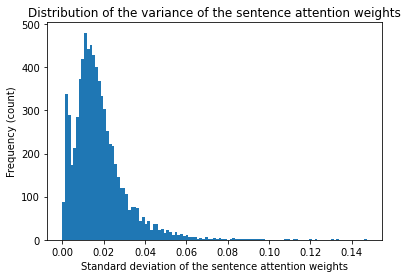

In [55]:
sentence_attention_var = [np.std(i) for i in sentence_weight_han]
import matplotlib.pyplot as plt
plt.hist(sentence_attention_var, bins='auto')
plt.xlabel("Standard deviation of the sentence attention weights")
plt.ylabel("Frequency (count)")
plt.title("Distribution of the variance of the sentence attention weights")
plt.show()

We see indeed that the standard deviation of the sentence attention weights is very small. 

In [56]:
len(sentence_attention_var)

7584

In [0]:
max_sentence_attention_var = max([np.std(i) for i in sentence_weight_han])

In [59]:
max_sentence_attention_var

0.1472160369157791

In [60]:
res.head(3)

,index,predicted_class,true_class,highest_proba,pred_label,true_label,right_pred,sent_len
0,0,2,0,0.494858,New Democratic Party,Conservative,False,1
1,1,0,1,0.713409,Conservative,Liberal,False,1
2,2,0,1,0.593566,Conservative,Liberal,False,1


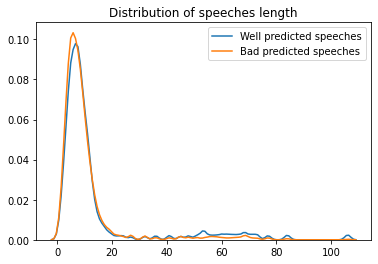

In [61]:
import seaborn as sns
sns.kdeplot(np.array(res[res.right_pred==True].sent_len), bw=1, label="Well predicted speeches").set_title("Distribution of speeches length")
sns.kdeplot(np.array(res[res.right_pred==False].sent_len), bw=1, label = "Bad predicted speeches")

In [62]:
res.groupby('right_pred')['sent_len'].quantile([.1, .25, .5, .75, .95, 1])

right_pred      
False       0.10      3.0
            0.25      5.0
            0.50      7.0
            0.75     10.0
            0.95     32.0
            1.00    106.0
True        0.10      4.0
            0.25      5.0
            0.50      8.0
            0.75     11.0
            0.95     62.0
            1.00    106.0
Name: sent_len, dtype: float64

>

## **Overview of the results**
* Sequence models perform better than baseline models. The highest accuracy and F1-score, which are respectively of 68.7\% and 68.6\%, are reached when using the Bi-LSTM model. 
* There is very little gain using HAN compared to using a SVM classfier on simpler documents features.
* Filtering beforehand the speeches according to their sentence emotional score drastically worsened the performances of baseline models. However, when using Bi-LSTM and HAN models on filtered speeches, resulting accuracy and F1-score are very similar to when keeping complete speeches.

>